# Analysis per epitopes

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml, config, datasets, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ID Performance

In [2]:
df_id = pd.read_csv(
    "../data/closed_performance_epitopes.tsv",
    sep='\t'
)
print(df_id.shape)
df_id.head(5)

(42, 7)


task  N_test_pos  N_test_neg     acc  recall  \
0  ONE_VS_ONE__1H0DE1__3VRL__0__42        5000        5000  0.9674  0.9418   
1  ONE_VS_ONE__1H0DE1__1NSN__0__42        5000        5000  0.8798  0.7668   
2  ONE_VS_ONE__1H0DE1__3RAJ__0__42        5000        5000  0.9266  0.8658   
3  ONE_VS_ONE__1H0DE1__5E94__0__42        5000        5000  0.9654  0.9422   
4  ONE_VS_ONE__1H0DE1__1WEJ__0__42        5000        5000  0.9544  0.9206   

   precision        f1  
0   0.992622  0.966544  
1   0.990698  0.864487  
2   0.985656  0.921848  
3   0.988045  0.964578  
4   0.987344  0.952805

In [3]:
df_id["task_obj"] = df_id["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x))
df_id["task_type"] = df_id["task_obj"].apply(lambda x: x.task_type.to_str())
df_id["pos_dataset"] = df_id["task_obj"].apply(lambda x: x.get_nco_ag_pos())
df_id["neg_dataset"] = df_id["task_obj"].apply(lambda x: x.get_nco_ag_neg())

df_id["ag_pos"] = df_id["pos_dataset"].apply(lambda x: x.split("_")[0])
df_id["ag_neg"] = df_id["neg_dataset"].apply(lambda x: x.split("_")[0])

df_id["task_type_clean"] = df_id["task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

selector = (df_id["task_type"] == "1v1") & (df_id["ag_neg"].isin(config.ANTIGEN_EPITOPES))
df_id.loc[selector, "task_type"] = "1v1_epitope"
df_id.loc[selector, "task_type_clean"] = "vs 1 (Epitopes)"

df_id.head()

task  N_test_pos  N_test_neg     acc  recall  \
0  ONE_VS_ONE__1H0DE1__3VRL__0__42        5000        5000  0.9674  0.9418   
1  ONE_VS_ONE__1H0DE1__1NSN__0__42        5000        5000  0.8798  0.7668   
2  ONE_VS_ONE__1H0DE1__3RAJ__0__42        5000        5000  0.9266  0.8658   
3  ONE_VS_ONE__1H0DE1__5E94__0__42        5000        5000  0.9654  0.9422   
4  ONE_VS_ONE__1H0DE1__1WEJ__0__42        5000        5000  0.9544  0.9206   

   precision        f1                         task_obj task_type pos_dataset  \
0   0.992622  0.966544  ONE_VS_ONE__1H0DE1__3VRL__0__42       1v1      1H0DE1   
1   0.990698  0.864487  ONE_VS_ONE__1H0DE1__1NSN__0__42       1v1      1H0DE1   
2   0.985656  0.921848  ONE_VS_ONE__1H0DE1__3RAJ__0__42       1v1      1H0DE1   
3   0.988045  0.964578  ONE_VS_ONE__1H0DE1__5E94__0__42       1v1      1H0DE1   
4   0.987344  0.952805  ONE_VS_ONE__1H0DE1__1WEJ__0__42       1v1      1H0DE1   

  neg_dataset  ag_pos ag_neg task_type_clean  
0        3VRL  1H0DE1   3VRL            vs 1  
1        1NSN  1H0DE1   1NSN            vs 1  
2        3RAJ  1H0DE1   3RAJ            vs 1  
3        5E94  1H0DE1   5E94            vs 1  
4        1WEJ  1H0DE1   1WEJ            vs 1

/tmp/ipykernel_3015274/1807728475.py:30: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(


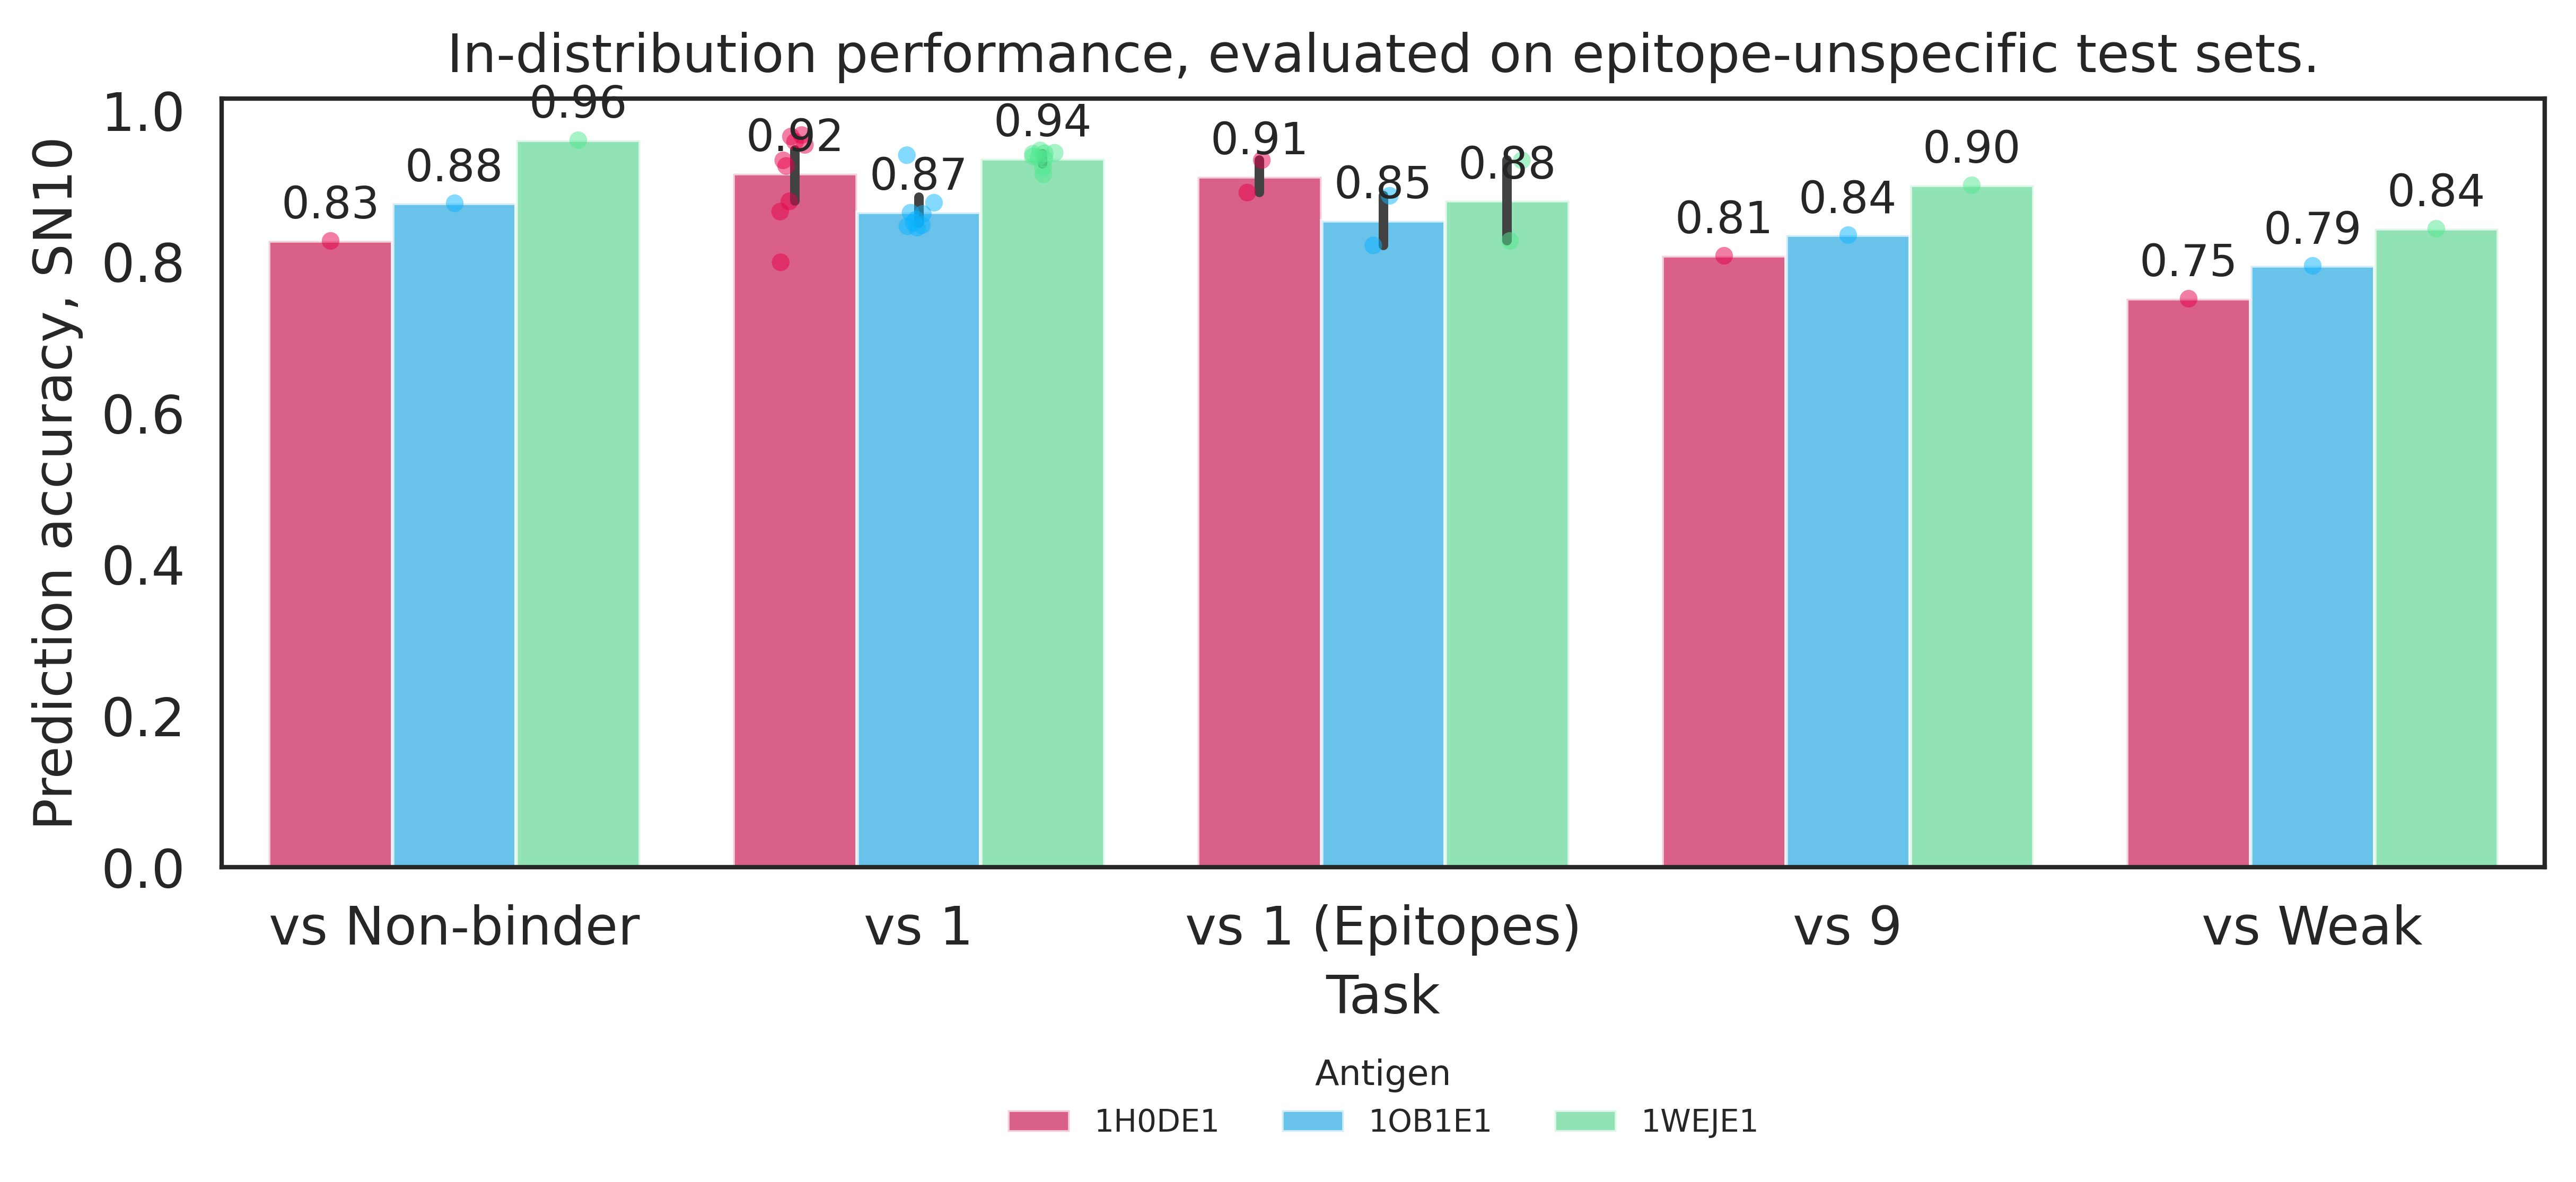

In [4]:
# This is a plot of overall performance on the same test sets that are being
# used for non-epitope specific. It provides a direct comparison!

# In this case, both the positive and negative parts of the test set contain
# epitopes that were not found in the training set.

ag_order = visualisations.PlotParams.order_antigens
task_order = ["high_vs_95low", "1v1", "1v1_epitope", "1v9", "high_vs_looser"]
task_clean_order = [visualisations.PlotParams.map_task_type_to_clean[x] for x in task_order]
cmap = visualisations.PlotParams.cmap_antigens


sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.barplot(
    x="task_type_clean",
    y="acc",
    hue="ag_pos",
    data=df_id,
    ax=ax,
    order=task_clean_order,
    # hue_order=ag_order,
    palette=cmap,
    alpha=0.7,
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="acc",
    hue="ag_pos",
    data=df_id,
    ax=ax,
    order=task_clean_order,
    # hue_order=ag_order,
    palette=cmap,
    alpha=0.5,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

# visualisations.add_median_labels(ax, y_level=0.85, fontsize=8)
for i in range(3):
    ax.bar_label(ax.containers[i], fontsize=10, fmt="%1.2f", label_type="edge", padding=3)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel("Prediction accuracy, SN10", fontsize=12)
ax.set_title("In-distribution performance, evaluated on epitope-unspecific test sets.", fontsize=12)

# fig.savefig("")
fig.show()

In [5]:
# JSD

df_jsd = pd.read_csv(
    "../data/jsd_epitopes.tsv",
    sep='\t'
)
df_jsd.dropna(inplace=True)

df_id = pd.merge(
    df_id,
    df_jsd,
    on=["task"],
    how="inner"
)

In [7]:
from scipy.stats import pearsonr


def plot_acc_jsd(df):
    cmap = visualisations.PlotParams.cmap_tasks

    order_tasks = ["high_vs_95low", "1v1", "1v9", "high_vs_looser", "1v1_epitope"]
    order_tasks_clean = list(map(lambda x: visualisations.map_task_type_to_clean[x], order_tasks))

    sns.set_theme(context="paper")
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

    # Line plot in seaborn with R2 regression
    for i, df_g in df.groupby("task_type_clean"):
        print(i)
        color = cmap[order_tasks_clean.index(i)] # type: ignore
        sns.regplot(
            x="jsd",
            y="acc",
            data=df_g,
            scatter=True,
            color=color,
            ax=ax,
            label=i,
        )

        # Compute Pearson correlation
        r, pval = pearsonr(df_g["jsd"], df_g["acc"])
        print(f"{i}: r={r:.2f}, p={pval:.2f}")
        # Add text with r and R2 at centroid
        x = df_g["jsd"].mean()
        y = df_g["acc"].mean()
        ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

    FONT_SIZE = 12
    ax.tick_params(labelsize=FONT_SIZE)
    ax.legend(
        bbox_to_anchor=(0.5, -0.3),
        loc="center",
        borderaxespad=0.0,
        fontsize=7,
        title="Task",
        title_fontsize=8,
        ncol=10,
        frameon=False,
    )
    ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
    ax.set_ylabel("Accuracy", fontsize=FONT_SIZE)

vs 1
vs 1: r=0.41, p=0.03
vs 1 (Epitopes)
vs 1 (Epitopes): r=0.66, p=0.15
vs 9
vs 9: r=-0.58, p=0.60
vs Non-binder
vs Non-binder: r=-0.47, p=0.69
vs Weak
vs Weak: r=1.00, p=0.05


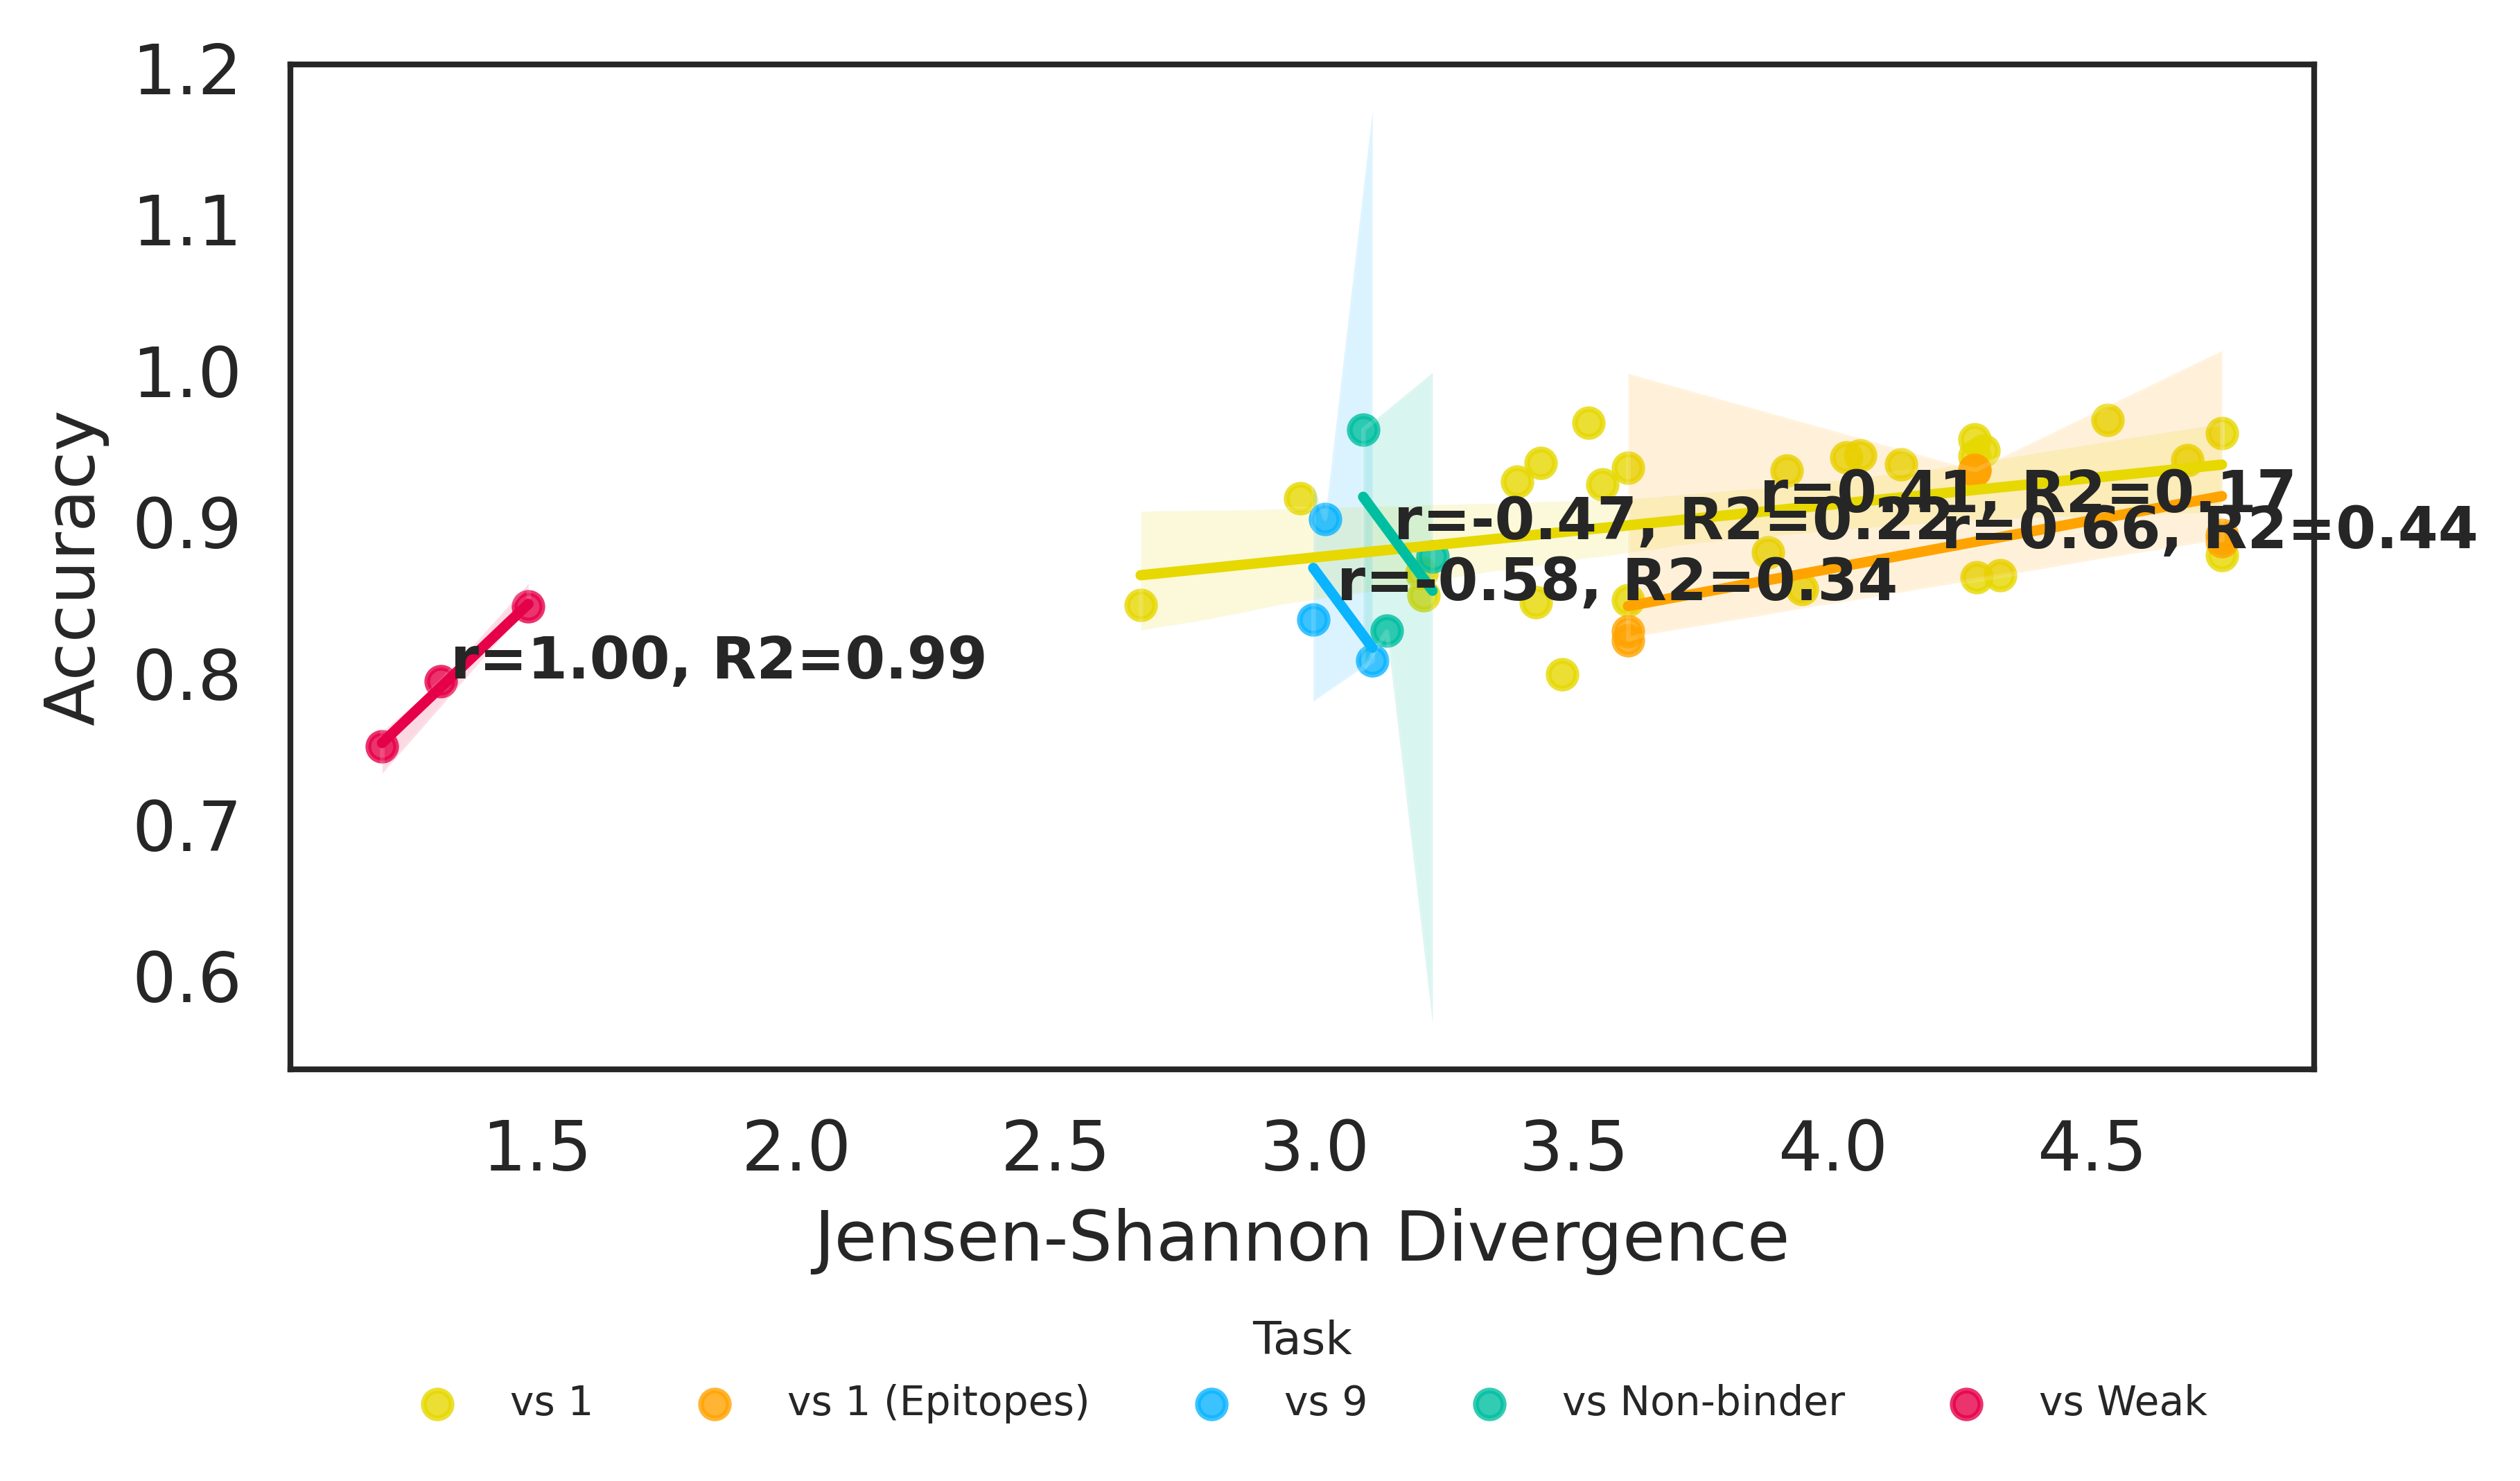

In [8]:
plot_acc_jsd(df_id)

In [ ]:
# Do the analysis for a few more scenarios
# 1) +: only epitope specific, -: epitope non-specific (as previously)
# 2) + and -: only epitope specific (where possible: 1v1_epitopes, vs W, vs Nonb)

/tmp/ipykernel_3015274/4286023776.py:59: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(


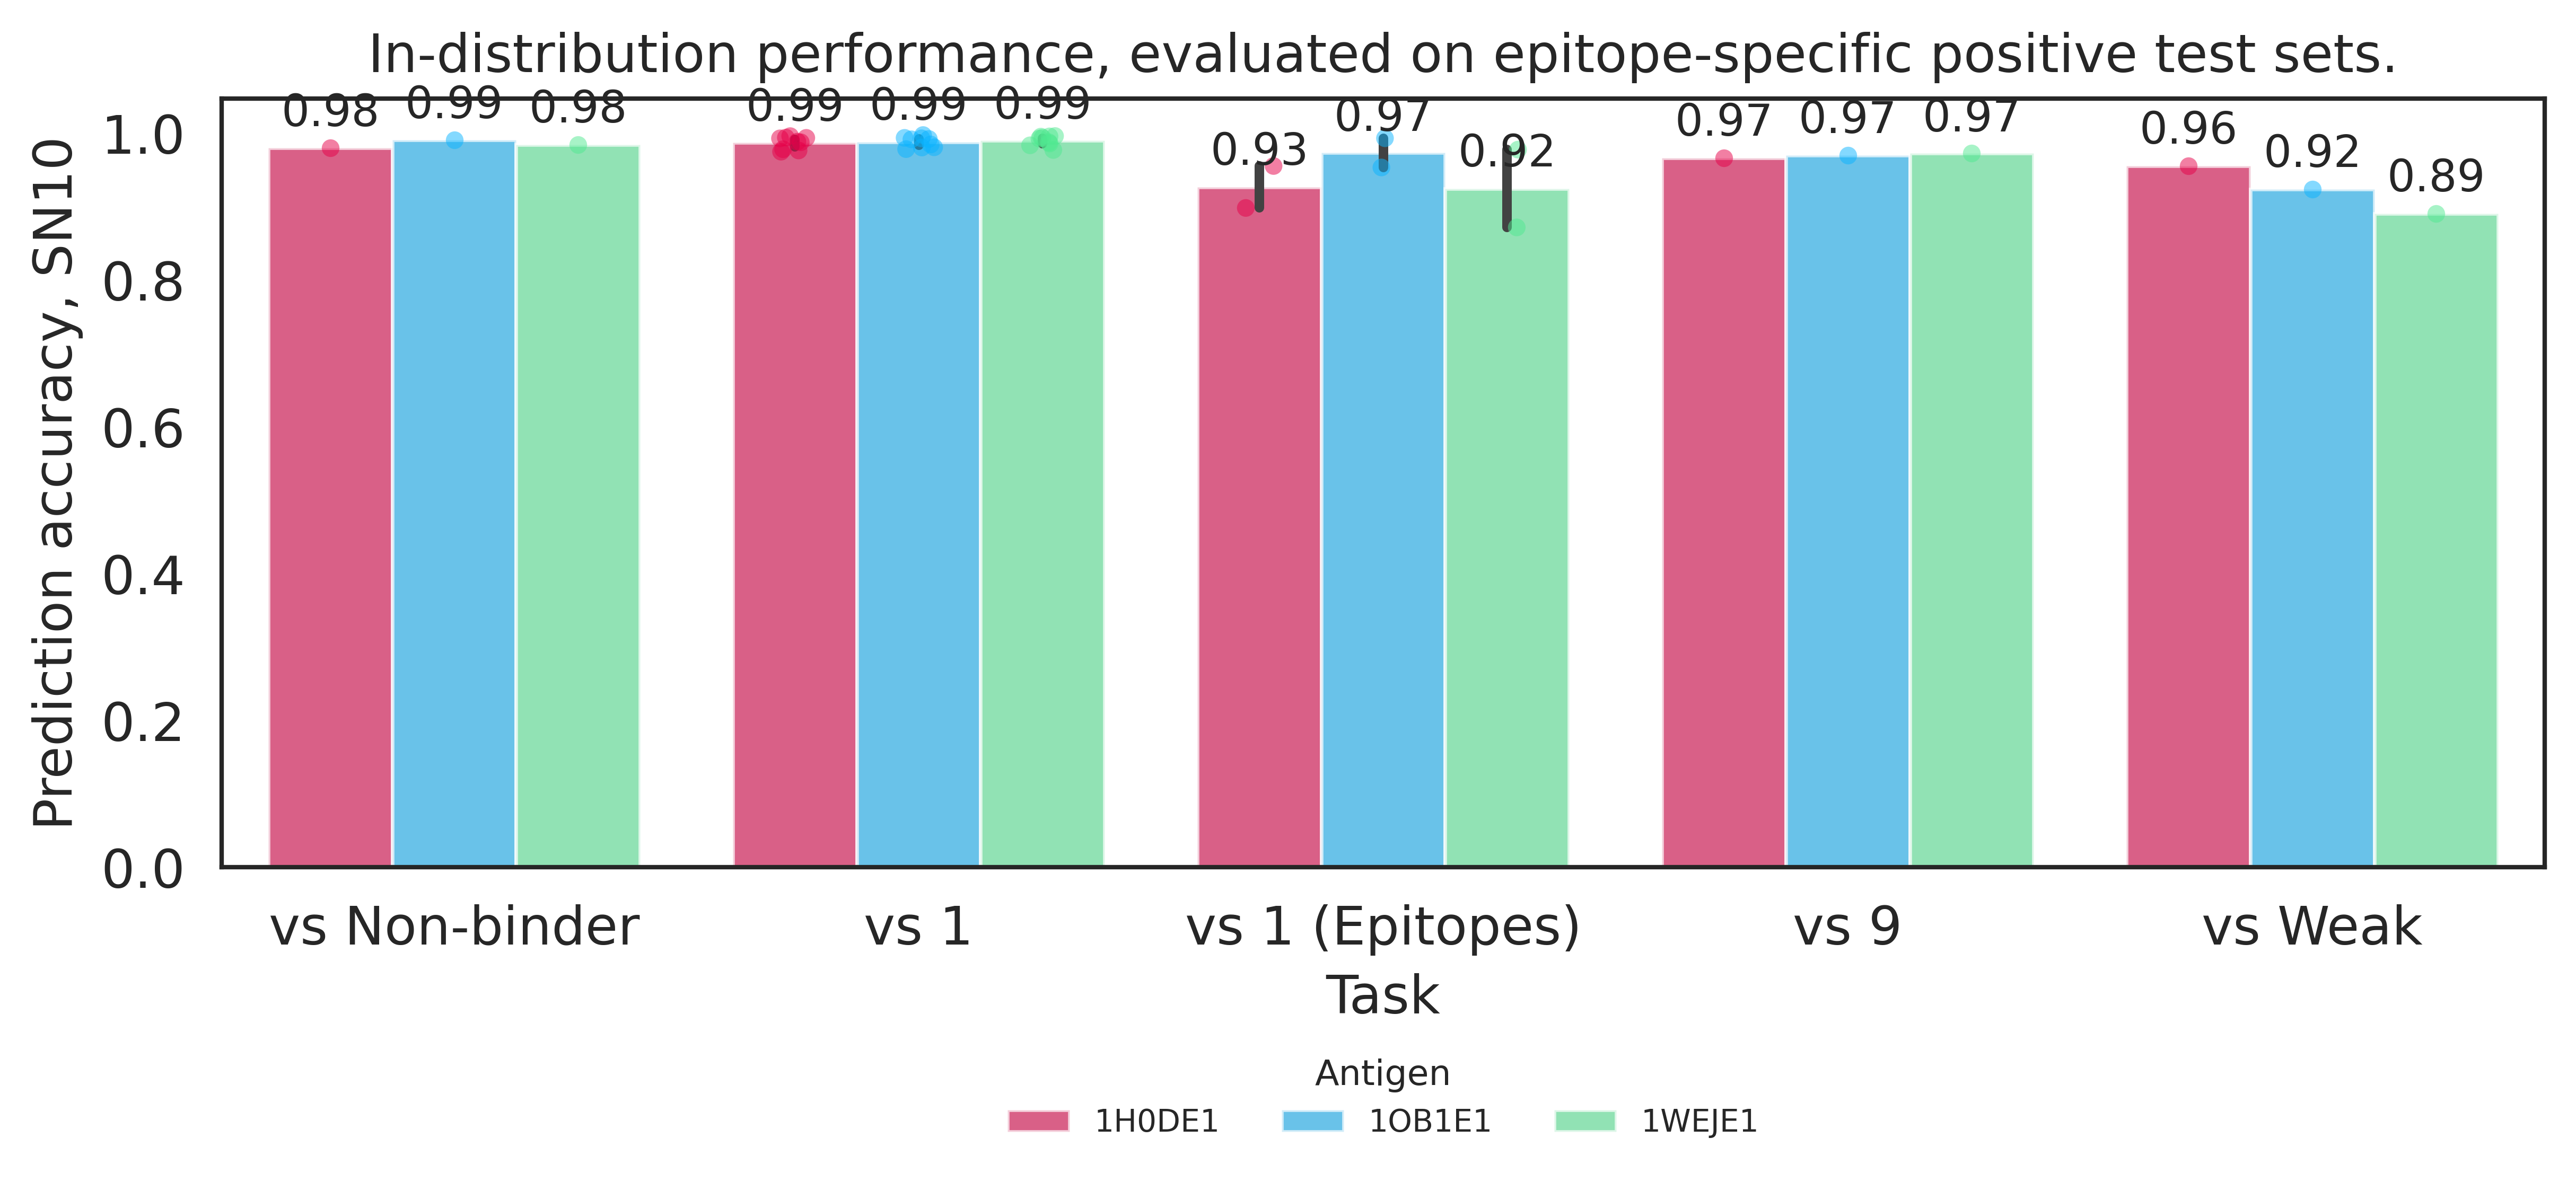

In [9]:
## 1) +: only epitope specific, -: epitope non-specific (as previously)

## To make the analysis easier, we generated adapted test sets in MiniAbsolut
## for this scenario: 01c2_Epitopes_to_MiniAbsolut.ipynb.

## We then evaluate the performance on the new test sets in 
## script 14/14b, which mimics transfer of frozen performance, with
## the only caveat of the test set being different. It loads the same task (model),
## but evaluates it on different test sets and adds a column to the same file (acc_epi_pos).


### REFACTOR using functions


df_id = pd.read_csv(
    "../data/closed_performance_epitopes_pos.tsv",
    sep='\t'
)


df_id["task_obj"] = df_id["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x))
df_id["task_type"] = df_id["task_obj"].apply(lambda x: x.task_type.to_str())
df_id["pos_dataset"] = df_id["task_obj"].apply(lambda x: x.get_nco_ag_pos())
df_id["neg_dataset"] = df_id["task_obj"].apply(lambda x: x.get_nco_ag_neg())

df_id["ag_pos"] = df_id["pos_dataset"].apply(lambda x: x.split("_")[0])
df_id["ag_neg"] = df_id["neg_dataset"].apply(lambda x: x.split("_")[0])

df_id["task_type_clean"] = df_id["task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

selector = (df_id["task_type"] == "1v1") & (df_id["ag_neg"].isin(config.ANTIGEN_EPITOPES))
df_id.loc[selector, "task_type"] = "1v1_epitope"
df_id.loc[selector, "task_type_clean"] = "vs 1 (Epitopes)"


ag_order = visualisations.PlotParams.order_antigens
task_order = ["high_vs_95low", "1v1", "1v1_epitope", "1v9", "high_vs_looser"]
task_clean_order = [visualisations.PlotParams.map_task_type_to_clean[x] for x in task_order]
cmap = visualisations.PlotParams.cmap_antigens


sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.barplot(
    x="task_type_clean",
    y="acc_epi_pos",
    hue="ag_pos",
    data=df_id,
    ax=ax,
    order=task_clean_order,
    # hue_order=ag_order,
    palette=cmap,
    alpha=0.7,
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="acc_epi_pos",
    hue="ag_pos",
    data=df_id,
    ax=ax,
    order=task_clean_order,
    # hue_order=ag_order,
    palette=cmap,
    alpha=0.5,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

# visualisations.add_median_labels(ax, y_level=0.85, fontsize=8)
for i in range(3):
    ax.bar_label(ax.containers[i], fontsize=10, fmt="%1.2f", label_type="edge", padding=3)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel("Prediction accuracy, SN10", fontsize=12)
ax.set_title("In-distribution performance, evaluated on epitope-specific positive test sets.", fontsize=12)

# fig.savefig("")
fig.show()

vs 1
vs 1: r=0.74, p=0.00
vs 1 (Epitopes)
vs 1 (Epitopes): r=0.64, p=0.17
vs 9
vs 9: r=0.06, p=0.96
vs Non-binder
vs Non-binder: r=0.42, p=0.72
vs Weak
vs Weak: r=0.22, p=0.86


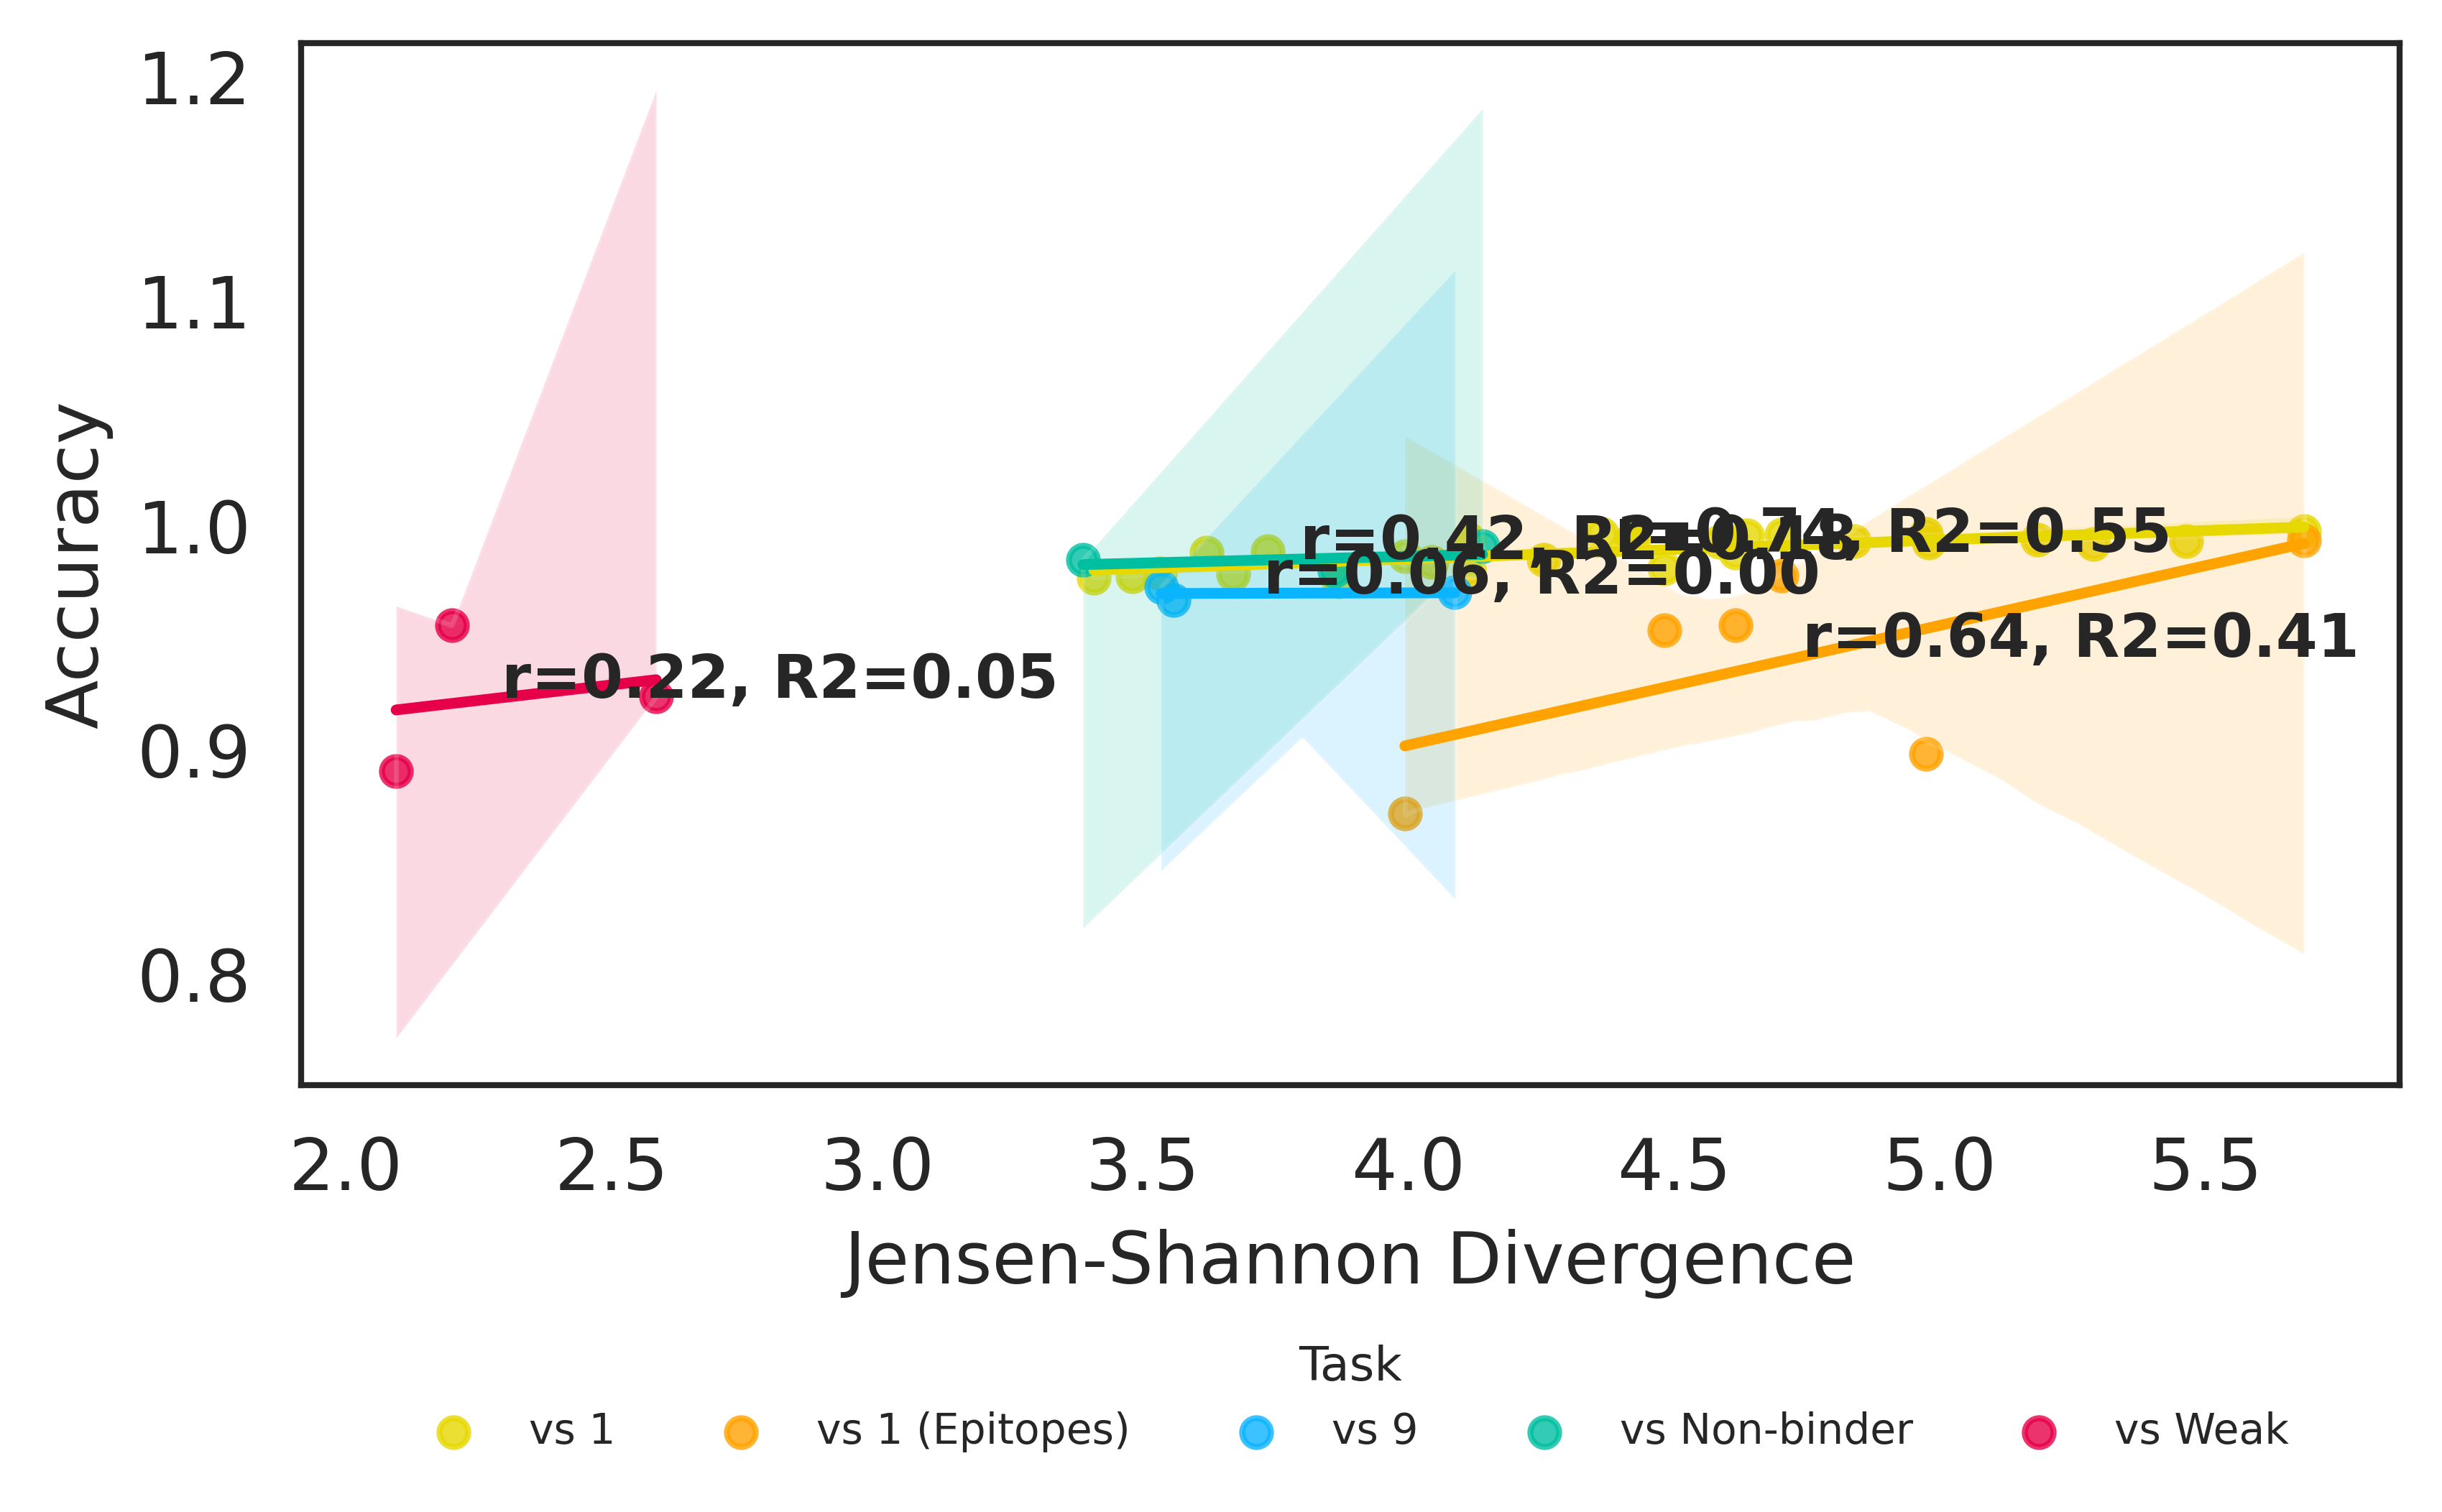

In [13]:
df_jsd = pd.read_csv(
    "../data/jsd_epitopes_pos.tsv",
    sep='\t'
)
df_jsd.dropna(inplace=True)

df_id = pd.merge(
    df_id,
    df_jsd,
    on=["task"],
    how="inner"
)

df_id["acc"] = df_id["acc_epi_pos"]

plot_acc_jsd(df_id)

/tmp/ipykernel_3015274/2861168674.py:53: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(


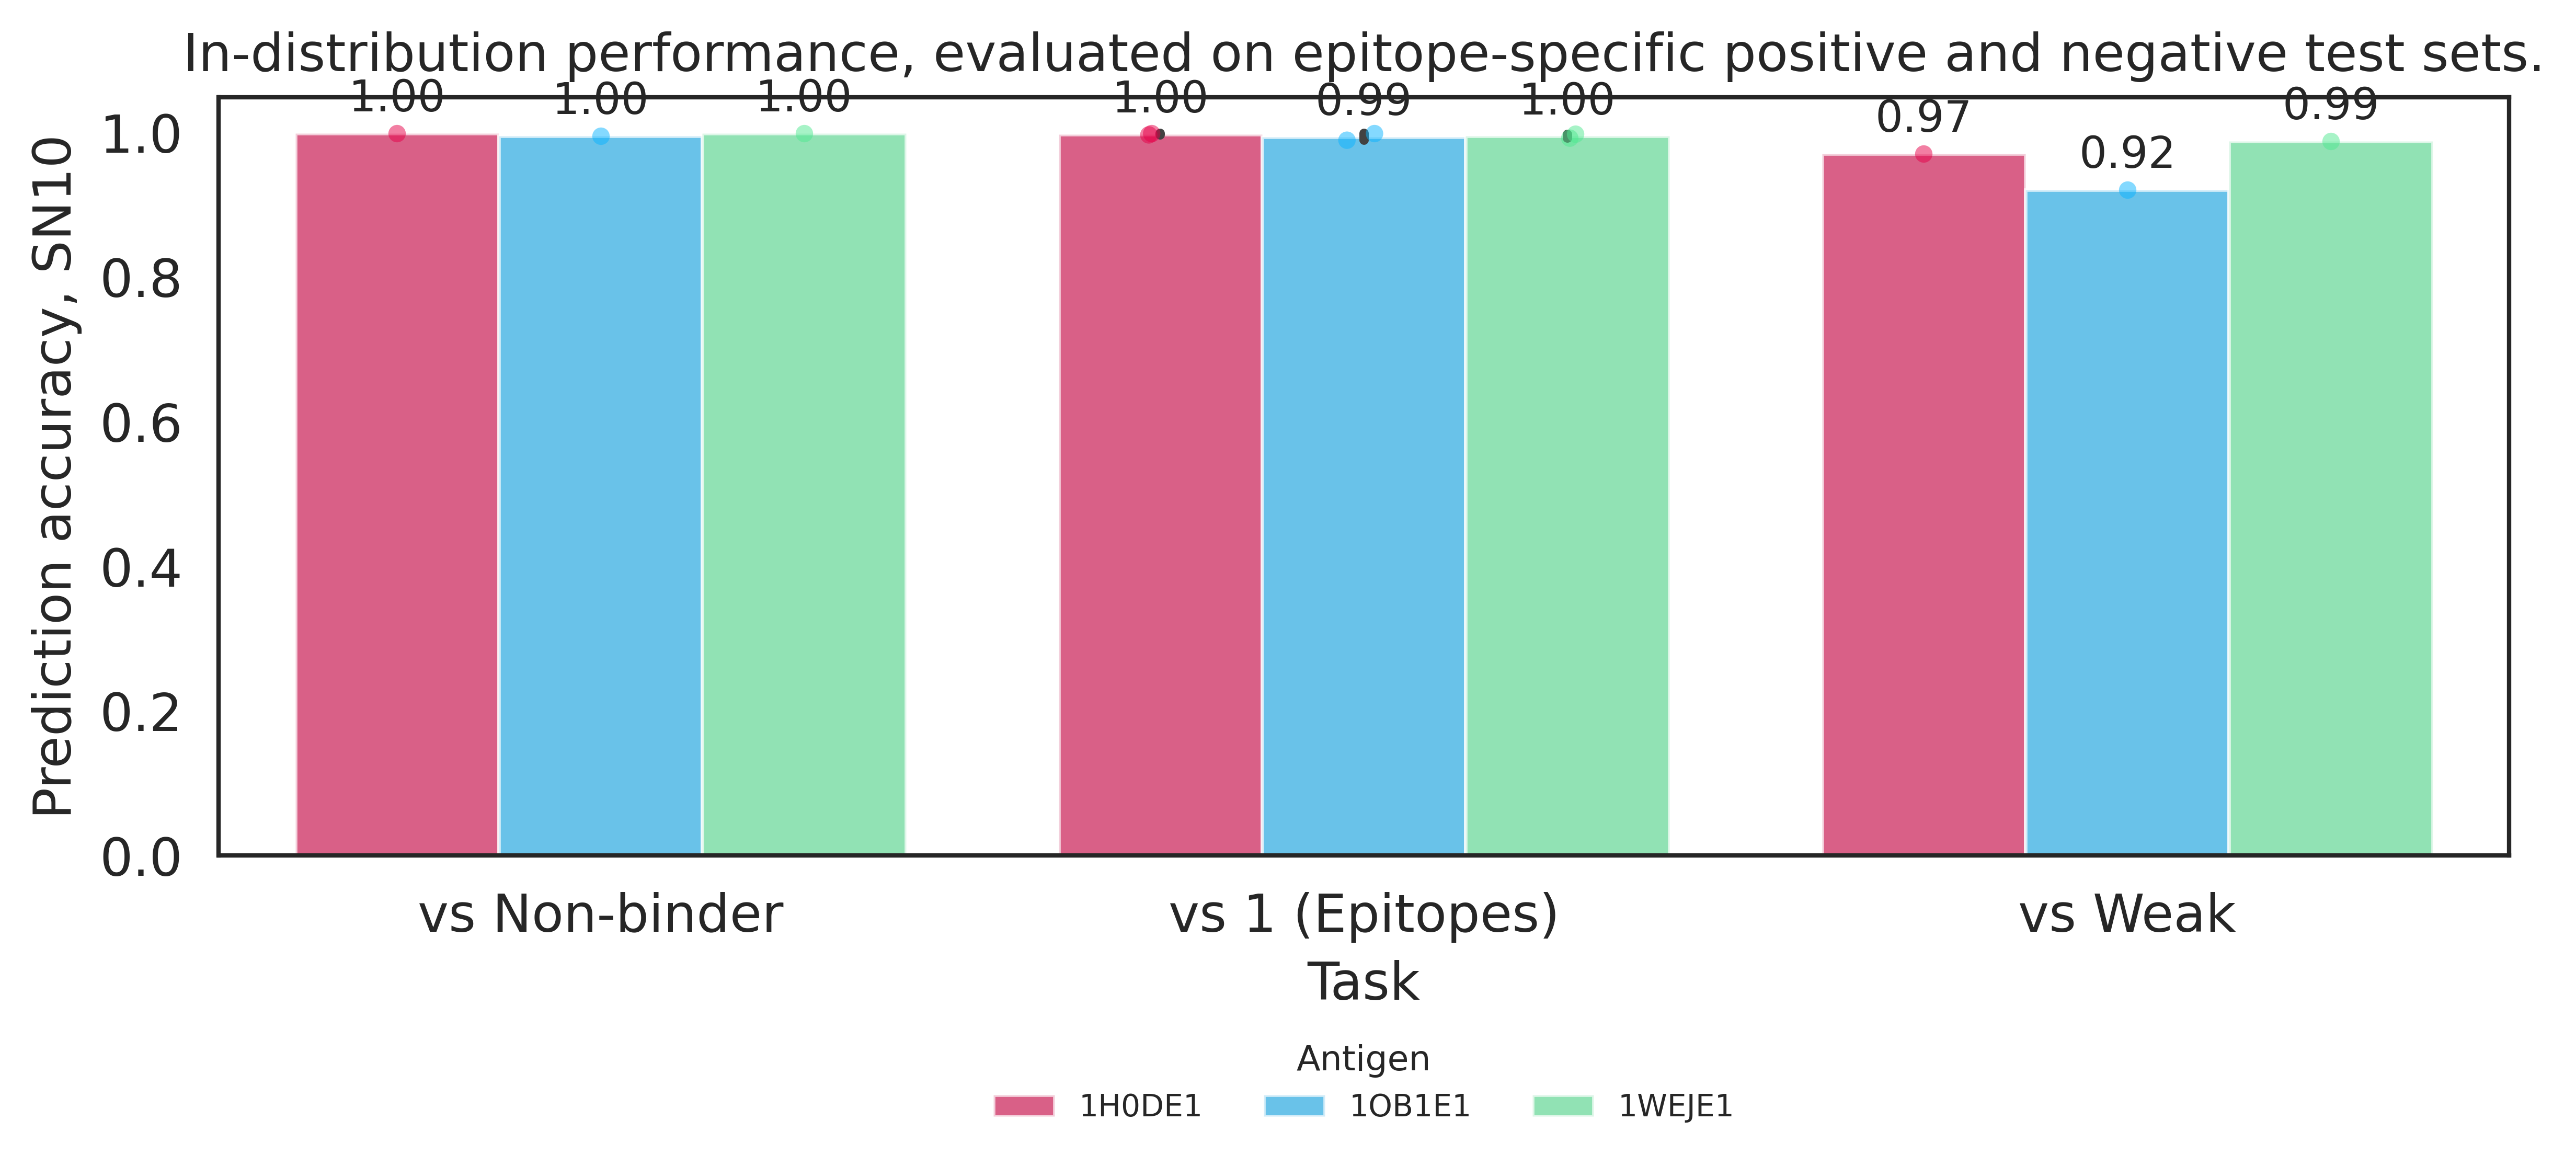

In [14]:
## 2) + and -: only epitope specific (where possible: 1v1_epitopes, vs W, vs Nonb)

## Same logic as above, but adds a column acc_epi_pos_and_neg


### REFACTOR using functions


df_id = pd.read_csv(
    "../data/closed_performance_epitopes_pos_and_neg.tsv",
    sep='\t'
)


df_id["task_obj"] = df_id["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x))
df_id["task_type"] = df_id["task_obj"].apply(lambda x: x.task_type.to_str())
df_id["pos_dataset"] = df_id["task_obj"].apply(lambda x: x.get_nco_ag_pos())
df_id["neg_dataset"] = df_id["task_obj"].apply(lambda x: x.get_nco_ag_neg())

df_id["ag_pos"] = df_id["pos_dataset"].apply(lambda x: x.split("_")[0])
df_id["ag_neg"] = df_id["neg_dataset"].apply(lambda x: x.split("_")[0])

df_id["task_type_clean"] = df_id["task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

selector = (df_id["task_type"] == "1v1") & (df_id["ag_neg"].isin(config.ANTIGEN_EPITOPES))
df_id.loc[selector, "task_type"] = "1v1_epitope"
df_id.loc[selector, "task_type_clean"] = "vs 1 (Epitopes)"


ag_order = visualisations.PlotParams.order_antigens
task_order = ["high_vs_95low", "1v1_epitope", "high_vs_looser"]
task_clean_order = [visualisations.PlotParams.map_task_type_to_clean[x] for x in task_order]
cmap = visualisations.PlotParams.cmap_antigens


sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.barplot(
    x="task_type_clean",
    y="acc",
    hue="ag_pos",
    data=df_id,
    ax=ax,
    order=task_clean_order,
    # hue_order=ag_order,
    palette=cmap,
    alpha=0.7,
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="acc",
    hue="ag_pos",
    data=df_id,
    ax=ax,
    order=task_clean_order,
    # hue_order=ag_order,
    palette=cmap,
    alpha=0.5,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

# visualisations.add_median_labels(ax, y_level=0.85, fontsize=8)
for i in range(3):
    ax.bar_label(ax.containers[i], fontsize=10, fmt="%1.2f", label_type="edge", padding=3)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel("Prediction accuracy, SN10", fontsize=12)
ax.set_title("In-distribution performance, evaluated on epitope-specific positive and negative test sets.", fontsize=12)

# fig.savefig("")
fig.show()

vs 1 (Epitopes)
vs 1 (Epitopes): r=0.73, p=0.10
vs Non-binder
vs Non-binder: r=-0.88, p=0.32
vs Weak
vs Weak: r=-0.79, p=0.42


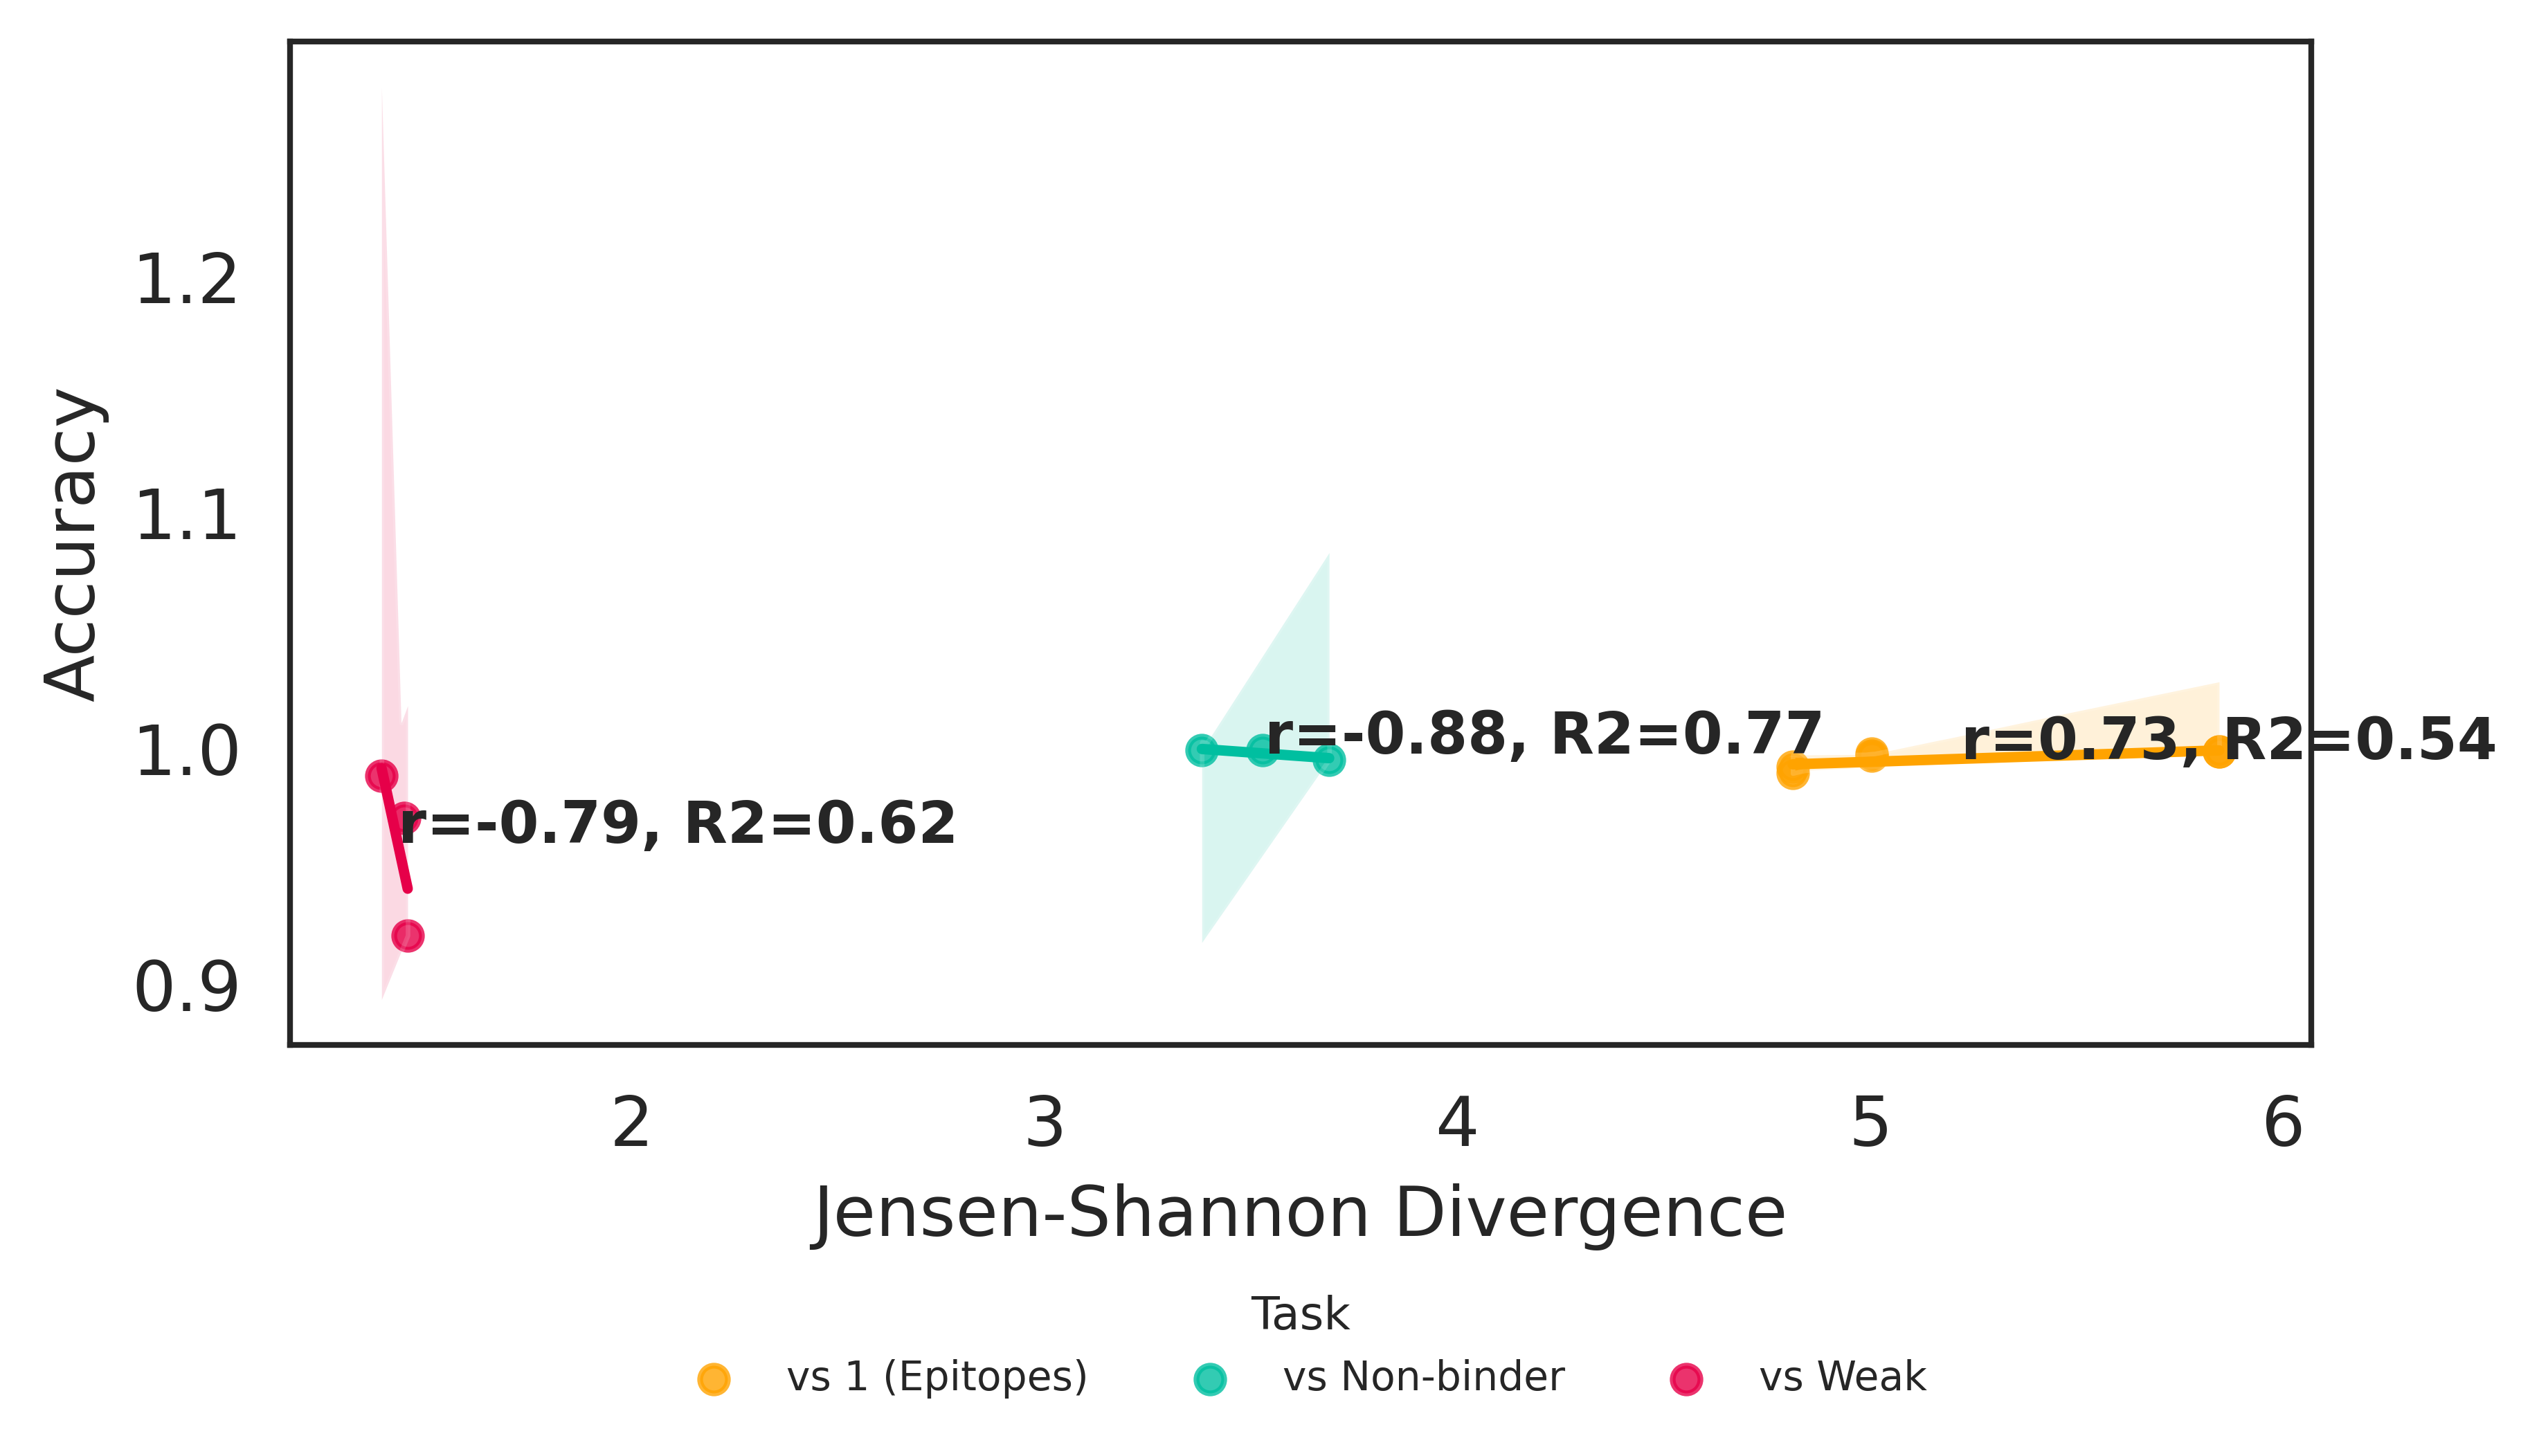

In [16]:
df_jsd = pd.read_csv(
    "../data/jsd_epitopes_pos_and_neg.tsv",
    sep='\t'
)
df_jsd.dropna(inplace=True)

df_id = pd.merge(
    df_id,
    df_jsd,
    on=["task"],
    how="inner"
)

plot_acc_jsd(df_id)

OOD Performance (later)

In [22]:
df_ood = pd.read_csv(
    "../data/openset_performance_epitopes.tsv",
    sep='\t'
)

df_ood["task_obj_1"] = df_ood["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x))
df_ood["task_obj_2"] = df_ood["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x))


df_ood["model_task_type"] = df_ood["task_obj_1"].apply(lambda x: x.task_type.to_str())
df_ood["test_task_type"] = df_ood["task_obj_2"].apply(lambda x: x.task_type.to_str())

df_ood["model_pos_dataset"] = df_ood["task_obj_1"].apply(lambda x: x.get_nco_ag_pos())
df_ood["model_neg_dataset"] = df_ood["task_obj_1"].apply(lambda x: x.get_nco_ag_neg())
df_ood["test_pos_dataset"] = df_ood["task_obj_2"].apply(lambda x: x.get_nco_ag_pos())
df_ood["test_neg_dataset"] = df_ood["task_obj_2"].apply(lambda x: x.get_nco_ag_neg())


df_ood["model_ag_pos"] = df_ood["model_pos_dataset"].apply(lambda x: x.split("_")[0])
df_ood["model_ag_neg"] = df_ood["model_neg_dataset"].apply(lambda x: x.split("_")[0])

df_ood["test_ag_pos"] = df_ood["test_pos_dataset"].apply(lambda x: x.split("_")[0])
df_ood["test_ag_neg"] = df_ood["test_neg_dataset"].apply(lambda x: x.split("_")[0])


df_ood["model_task_type_clean"] = df_ood["model_task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
df_ood["test_task_type_clean"] = df_ood["test_task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])


selector = (
    ((df_ood["model_task_type"] == "1v1") & (df_ood["model_ag_neg"].isin(config.ANTIGEN_EPITOPES)))
    |
    ((df_ood["test_task_type"] == "1v1") & (df_ood["test_ag_neg"].isin(config.ANTIGEN_EPITOPES)))
)
df_ood = df_ood.loc[~selector].copy()

print(df_ood.shape)
df_ood.head(5)

(432, 22)


task_1                           task_2  \
0  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__3VRL__0__42   
1  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__1NSN__0__42   
2  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__3RAJ__0__42   
3  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__5E94__0__42   
4  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__1WEJ__0__42   

   task_2_N_test_pos  task_2_N_test_neg     acc  recall  precision        f1  \
0               5000               5000  0.9674  0.9418   0.992622  0.966544   
1               5000               5000  0.7009  0.9418   0.635578  0.758965   
2               5000               5000  0.8464  0.9418   0.790897  0.859777   
3               5000               5000  0.6704  0.9418   0.610449  0.740758   
4               5000               5000  0.9064  0.9418   0.879529  0.909600   

                        task_obj_1                       task_obj_2  ...  \
0  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__3VRL__0__42  ...   
1  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__1NSN__0__42  ...   
2  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__3RAJ__0__42  ...   
3  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__5E94__0__42  ...   
4  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__1WEJ__0__42  ...   

  model_pos_dataset model_neg_dataset test_pos_dataset test_neg_dataset  \
0            1H0DE1              3VRL           1H0DE1             3VRL   
1            1H0DE1              3VRL           1H0DE1             1NSN   
2            1H0DE1              3VRL           1H0DE1             3RAJ   
3            1H0DE1              3VRL           1H0DE1             5E94   
4            1H0DE1              3VRL           1H0DE1             1WEJ   

  model_ag_pos model_ag_neg test_ag_pos test_ag_neg model_task_type_clean  \
0       1H0DE1         3VRL      1H0DE1        3VRL                  vs 1   
1       1H0DE1         3VRL      1H0DE1        1NSN                  vs 1   
2       1H0DE1         3VRL      1H0DE1        3RAJ                  vs 1   
3       1H0DE1         3VRL      1H0DE1        5E94                  vs 1   
4       1H0DE1         3VRL      1H0DE1        1WEJ                  vs 1   

  test_task_type_clean  
0                 vs 1  
1                 vs 1  
2                 vs 1  
3                 vs 1  
4                 vs 1  

[5 rows x 22 columns]

In [34]:
task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
def plot_ood(df_ood, task_order=task_order):
    ## CODE adapted from 25_Section_1.ipynb

    fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.2 * 3.14), dpi=600)
    sns.pointplot(
        df_ood,
        y="acc",
        x="test_task_type",
        errorbar="sd",
        order=task_order,
        hue="model_task_type",
        hue_order=task_order,
        palette=cmap,
        # Spread out the points a bit in horizontal
        dodge=0.3,
        ax=ax,
    )

    # Add legend horizontally on top of plot area, outside plot area
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=3,
        fontsize=8,
        frameon=False,
        # title="Model trained on",
        # title_fontsize=8,
    )

    ax.set_xlabel(None)
    ax.set_ylabel("Prediction accuracy")

    # Add text
    for i, col in enumerate(ax.collections):
        for j, txt in enumerate(col.get_offsets()[:, 0]):
            ax.text(
                txt,
                col.get_offsets()[j, 1],
                f"{col.get_offsets()[j, 1]:.2f}",
                ha="center",
                va="bottom",
                color="black",
                fontsize=8,
                fontweight="bold",
            )

    ax.set_title("OOD Performance for logistic regression")
    fig.show()

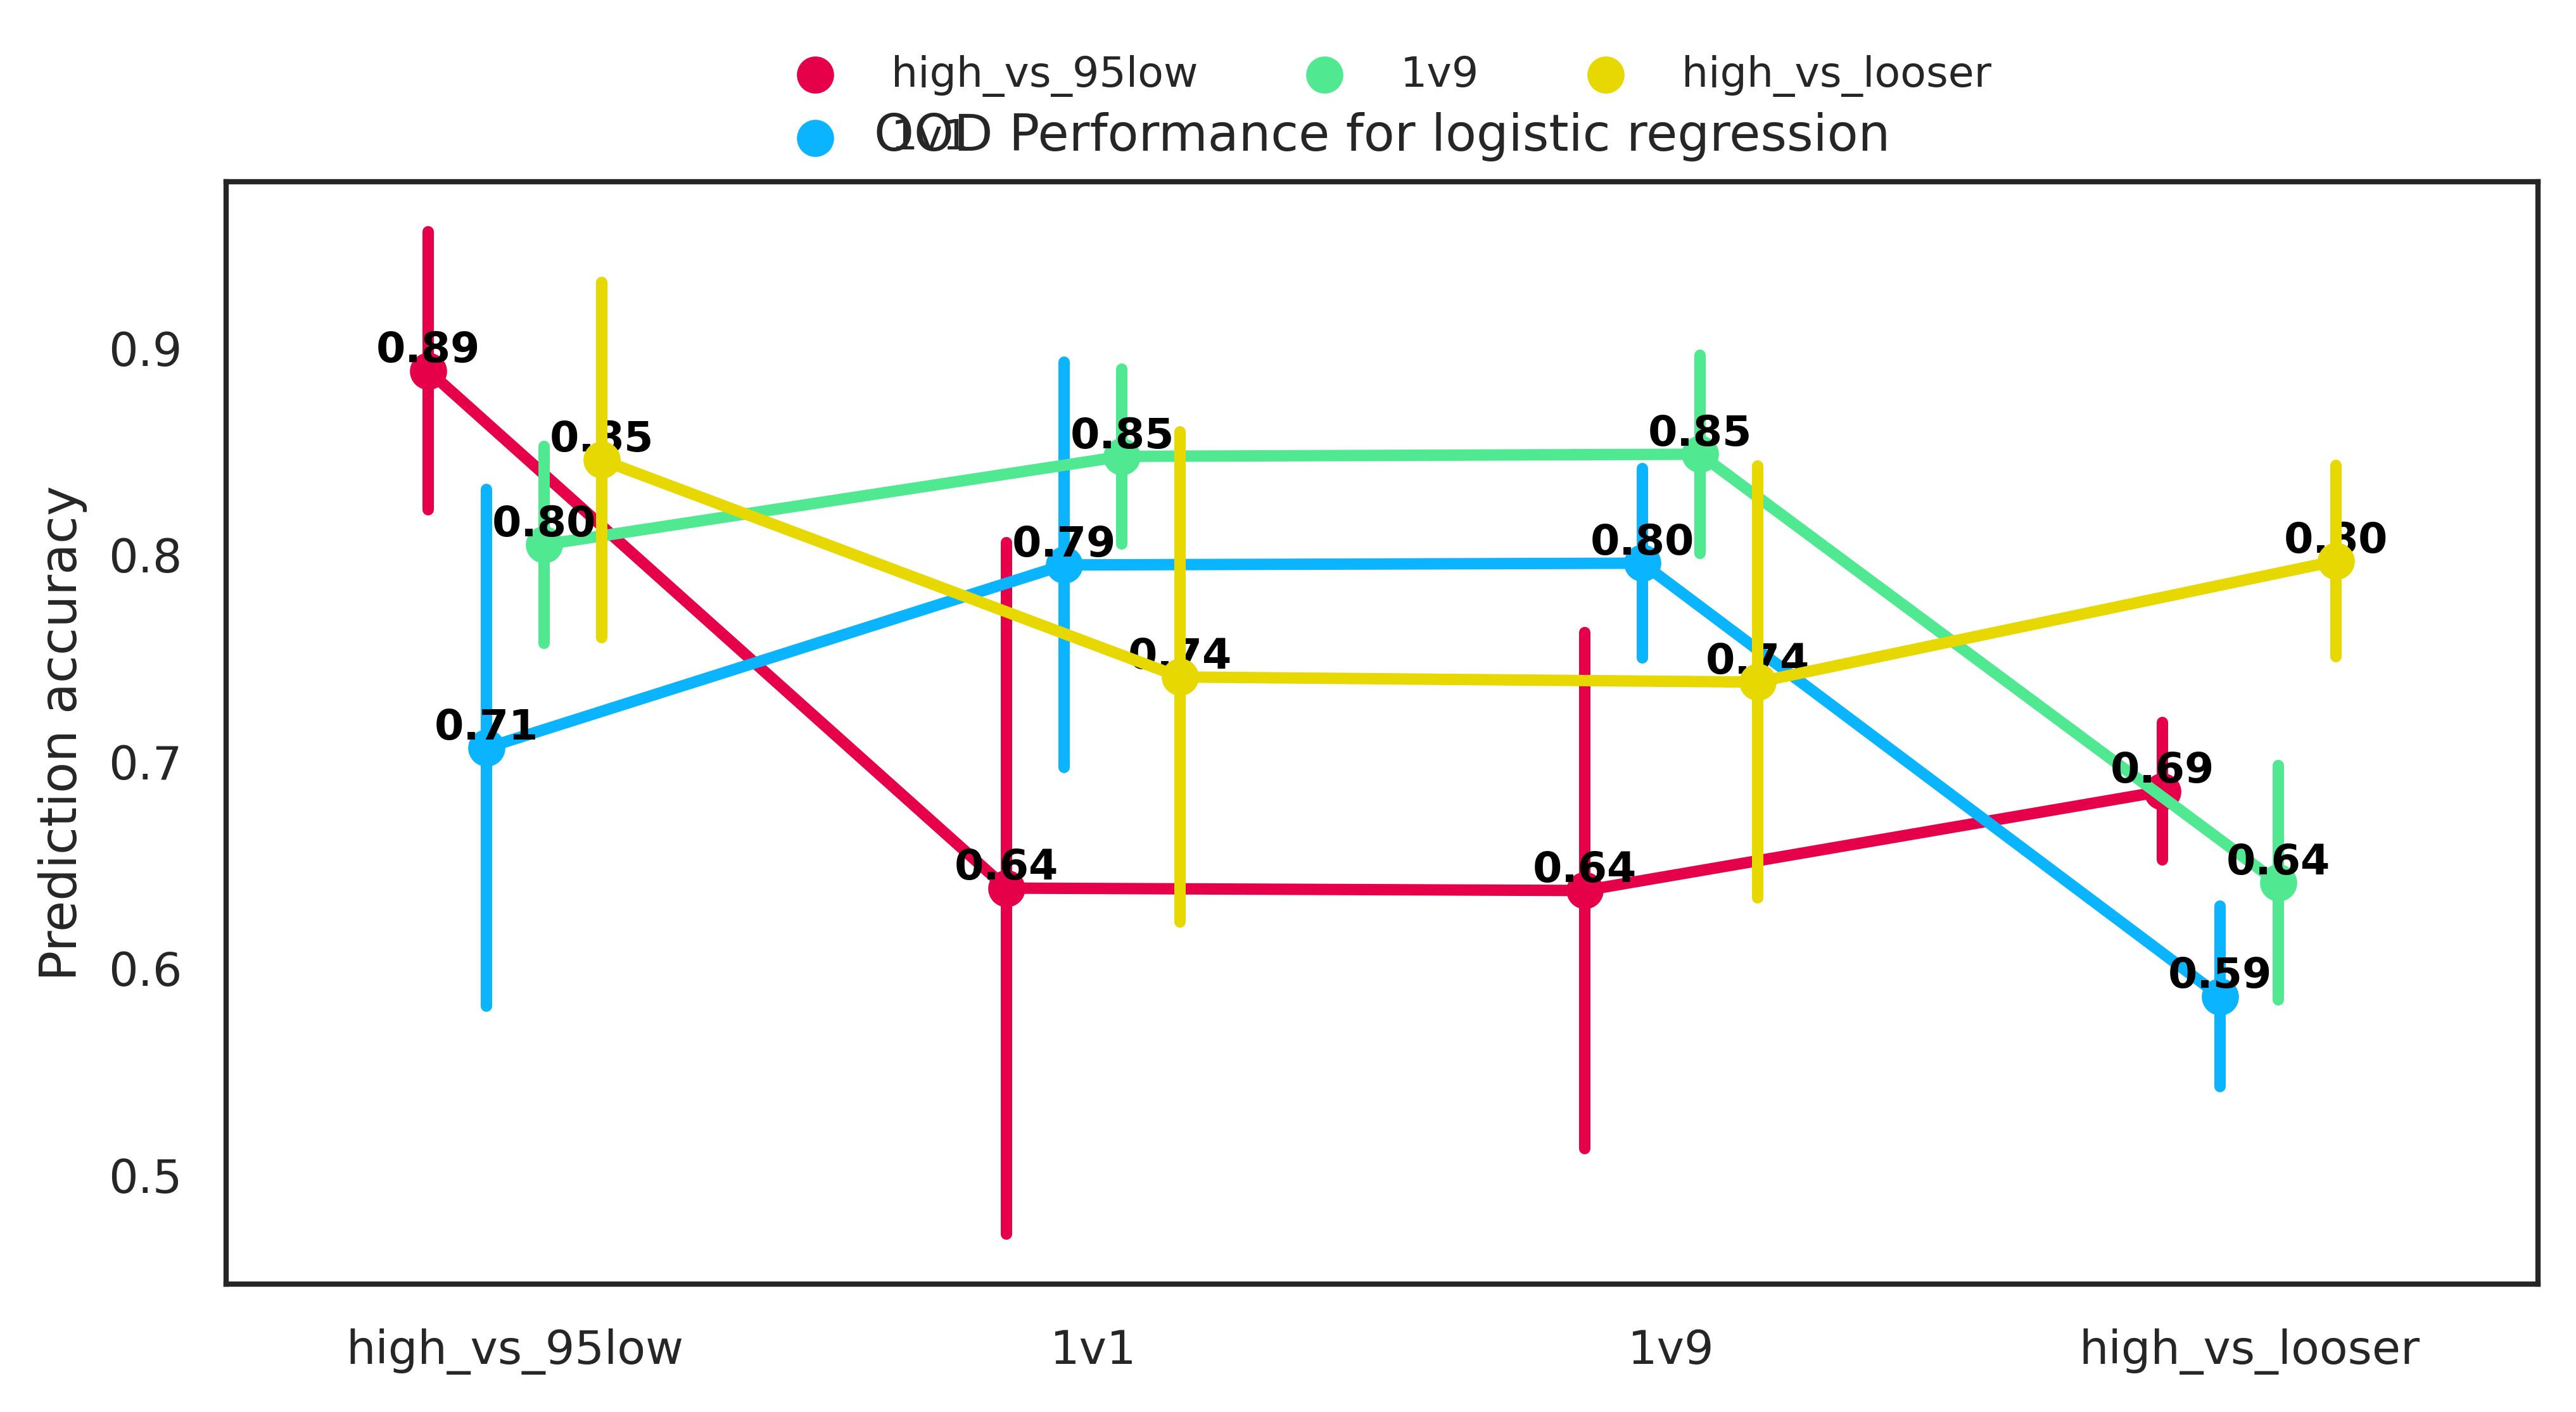

In [28]:
plot_ood(df_ood)

In [29]:
df_ood = pd.read_csv(
    "../data/openset_performance_epitopes_pos.tsv",
    sep='\t'
)

df_ood["task_obj_1"] = df_ood["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x))
df_ood["task_obj_2"] = df_ood["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x))


df_ood["model_task_type"] = df_ood["task_obj_1"].apply(lambda x: x.task_type.to_str())
df_ood["test_task_type"] = df_ood["task_obj_2"].apply(lambda x: x.task_type.to_str())

df_ood["model_pos_dataset"] = df_ood["task_obj_1"].apply(lambda x: x.get_nco_ag_pos())
df_ood["model_neg_dataset"] = df_ood["task_obj_1"].apply(lambda x: x.get_nco_ag_neg())
df_ood["test_pos_dataset"] = df_ood["task_obj_2"].apply(lambda x: x.get_nco_ag_pos())
df_ood["test_neg_dataset"] = df_ood["task_obj_2"].apply(lambda x: x.get_nco_ag_neg())


df_ood["model_ag_pos"] = df_ood["model_pos_dataset"].apply(lambda x: x.split("_")[0])
df_ood["model_ag_neg"] = df_ood["model_neg_dataset"].apply(lambda x: x.split("_")[0])

df_ood["test_ag_pos"] = df_ood["test_pos_dataset"].apply(lambda x: x.split("_")[0])
df_ood["test_ag_neg"] = df_ood["test_neg_dataset"].apply(lambda x: x.split("_")[0])


df_ood["model_task_type_clean"] = df_ood["model_task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
df_ood["test_task_type_clean"] = df_ood["test_task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])


selector = (
    ((df_ood["model_task_type"] == "1v1") & (df_ood["model_ag_neg"].isin(config.ANTIGEN_EPITOPES)))
    |
    ((df_ood["test_task_type"] == "1v1") & (df_ood["test_ag_neg"].isin(config.ANTIGEN_EPITOPES)))
)
df_ood = df_ood.loc[~selector].copy()

print(df_ood.shape)
df_ood.head(5)

(432, 22)


task_1                           task_2  \
0  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__3VRL__0__42   
1  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__1NSN__0__42   
2  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__3RAJ__0__42   
3  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__5E94__0__42   
4  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__1WEJ__0__42   

   task_2_N_test_pos  task_2_N_test_neg       acc  recall  precision  \
0               3000               3000  0.993167   0.992   0.994320   
1               3000               3000  0.726333   0.992   0.647801   
2               3000               3000  0.871667   0.992   0.799570   
3               3000               3000  0.697667   0.992   0.624423   
4               3000               3000  0.932167   0.992   0.885978   

         f1                       task_obj_1                       task_obj_2  \
0  0.993159  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__3VRL__0__42   
1  0.783777  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__1NSN__0__42   
2  0.885451  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__3RAJ__0__42   
3  0.766418  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__5E94__0__42   
4  0.935996  ONE_VS_ONE__1H0DE1__3VRL__0__42  ONE_VS_ONE__1H0DE1__1WEJ__0__42   

   ... model_pos_dataset model_neg_dataset test_pos_dataset test_neg_dataset  \
0  ...            1H0DE1              3VRL           1H0DE1             3VRL   
1  ...            1H0DE1              3VRL           1H0DE1             1NSN   
2  ...            1H0DE1              3VRL           1H0DE1             3RAJ   
3  ...            1H0DE1              3VRL           1H0DE1             5E94   
4  ...            1H0DE1              3VRL           1H0DE1             1WEJ   

  model_ag_pos model_ag_neg test_ag_pos test_ag_neg model_task_type_clean  \
0       1H0DE1         3VRL      1H0DE1        3VRL                  vs 1   
1       1H0DE1         3VRL      1H0DE1        1NSN                  vs 1   
2       1H0DE1         3VRL      1H0DE1        3RAJ                  vs 1   
3       1H0DE1         3VRL      1H0DE1        5E94                  vs 1   
4       1H0DE1         3VRL      1H0DE1        1WEJ                  vs 1   

  test_task_type_clean  
0                 vs 1  
1                 vs 1  
2                 vs 1  
3                 vs 1  
4                 vs 1  

[5 rows x 22 columns]

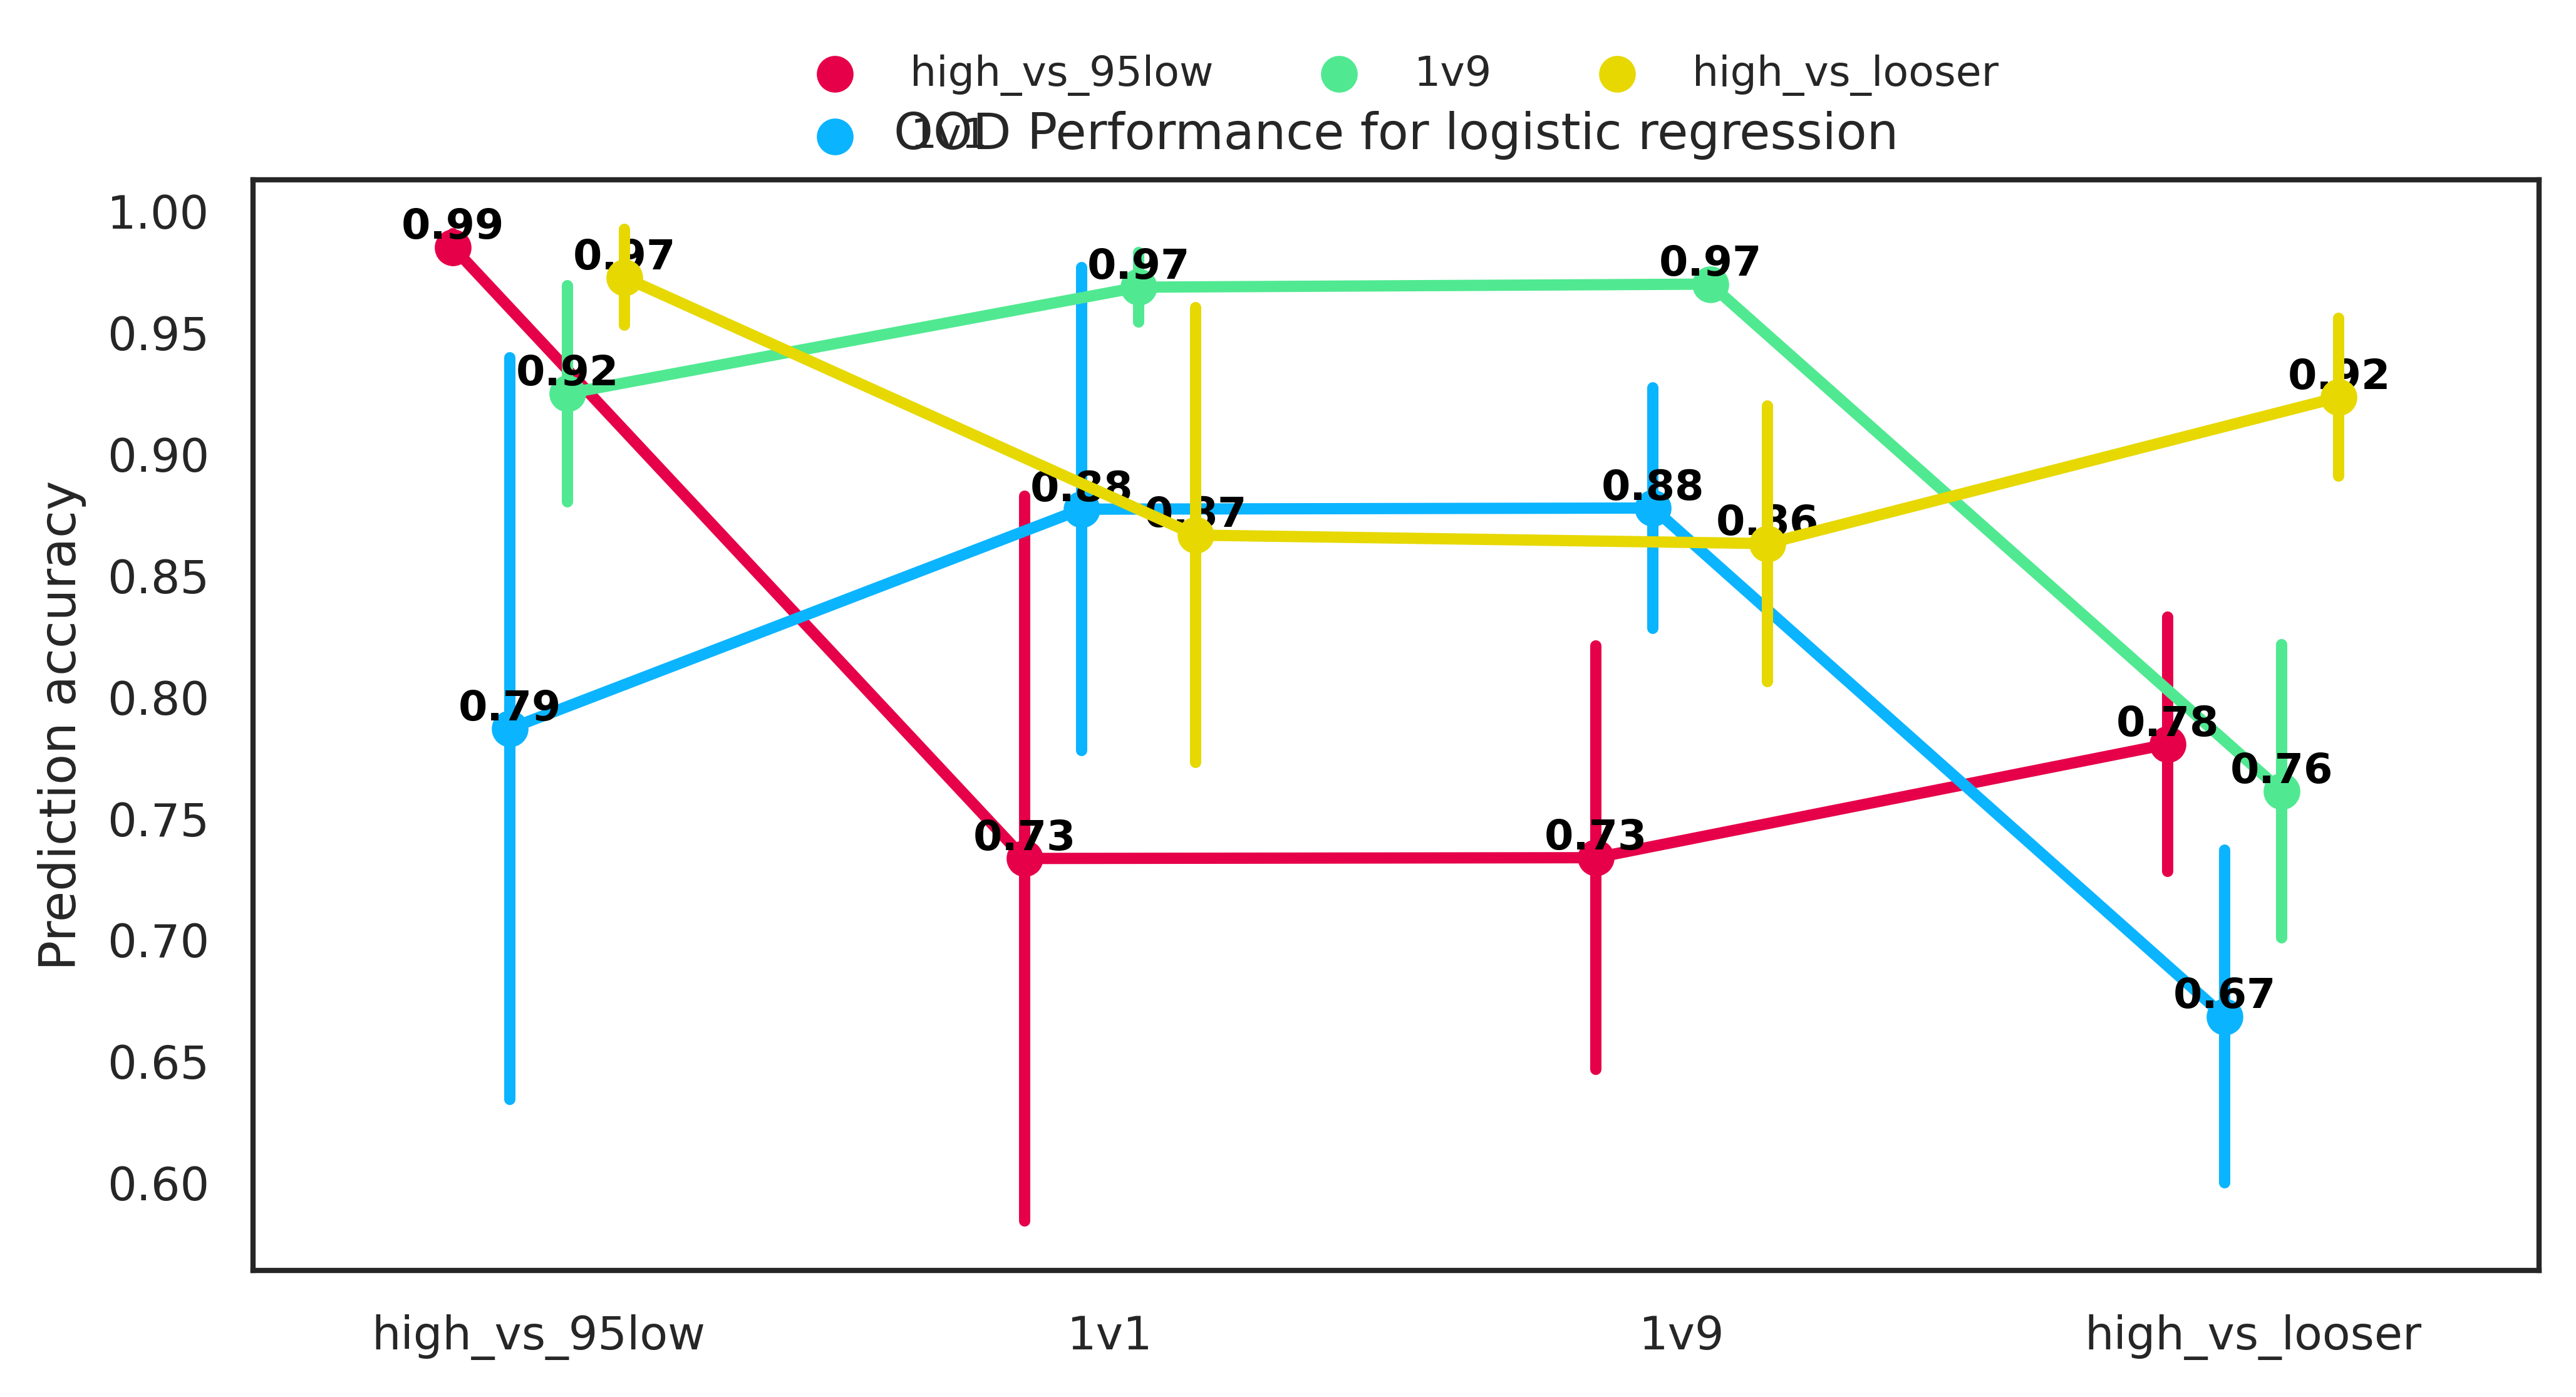

In [30]:
plot_ood(df_ood)

In [35]:
df_ood = pd.read_csv(
    "../data/openset_performance_epitopes_pos_and_neg.tsv",
    sep='\t'
)

df_ood["task_obj_1"] = df_ood["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x))
df_ood["task_obj_2"] = df_ood["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x))


df_ood["model_task_type"] = df_ood["task_obj_1"].apply(lambda x: x.task_type.to_str())
df_ood["test_task_type"] = df_ood["task_obj_2"].apply(lambda x: x.task_type.to_str())

df_ood["model_pos_dataset"] = df_ood["task_obj_1"].apply(lambda x: x.get_nco_ag_pos())
df_ood["model_neg_dataset"] = df_ood["task_obj_1"].apply(lambda x: x.get_nco_ag_neg())
df_ood["test_pos_dataset"] = df_ood["task_obj_2"].apply(lambda x: x.get_nco_ag_pos())
df_ood["test_neg_dataset"] = df_ood["task_obj_2"].apply(lambda x: x.get_nco_ag_neg())


df_ood["model_ag_pos"] = df_ood["model_pos_dataset"].apply(lambda x: x.split("_")[0])
df_ood["model_ag_neg"] = df_ood["model_neg_dataset"].apply(lambda x: x.split("_")[0])

df_ood["test_ag_pos"] = df_ood["test_pos_dataset"].apply(lambda x: x.split("_")[0])
df_ood["test_ag_neg"] = df_ood["test_neg_dataset"].apply(lambda x: x.split("_")[0])


df_ood["model_task_type_clean"] = df_ood["model_task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
df_ood["test_task_type_clean"] = df_ood["test_task_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])


selector = (
    ((df_ood["model_task_type"] == "1v1") & (df_ood["model_ag_neg"].isin(config.ANTIGEN_EPITOPES)))
    |
    ((df_ood["test_task_type"] == "1v1") & (df_ood["test_ag_neg"].isin(config.ANTIGEN_EPITOPES)))
)
df_ood = df_ood.loc[~selector].copy()

print(df_ood.shape)
df_ood.head(5)

(12, 22)


task_1                               task_2  \
0    HIGH_VS_95LOW__1H0DE1__auto__0__42   HIGH_VS_95LOW__1H0DE1__auto__0__42   
1    HIGH_VS_95LOW__1H0DE1__auto__0__42  HIGH_VS_LOOSER__1H0DE1__auto__0__42   
4   HIGH_VS_LOOSER__1H0DE1__auto__0__42   HIGH_VS_95LOW__1H0DE1__auto__0__42   
5   HIGH_VS_LOOSER__1H0DE1__auto__0__42  HIGH_VS_LOOSER__1H0DE1__auto__0__42   
21   HIGH_VS_95LOW__1OB1E1__auto__0__42   HIGH_VS_95LOW__1OB1E1__auto__0__42   

    task_2_N_test_pos  task_2_N_test_neg       acc    recall  precision  \
0                3000               3000  0.999167  0.999333   0.999000   
1                3000               3000  0.795000  0.999333   0.709418   
4                3000               3000  0.983833  0.967667   1.000000   
5                3000               3000  0.970667  0.967667   0.973508   
21               3000               3000  0.995333  1.000000   0.990753   

          f1                           task_obj_1  \
0   0.999167   HIGH_VS_95LOW__1H0DE1__auto__0__42   
1   0.829781   HIGH_VS_95LOW__1H0DE1__auto__0__42   
4   0.983568  HIGH_VS_LOOSER__1H0DE1__auto__0__42   
5   0.970578  HIGH_VS_LOOSER__1H0DE1__auto__0__42   
21  0.995355   HIGH_VS_95LOW__1OB1E1__auto__0__42   

                             task_obj_2  ... model_pos_dataset  \
0    HIGH_VS_95LOW__1H0DE1__auto__0__42  ...       1H0DE1_high   
1   HIGH_VS_LOOSER__1H0DE1__auto__0__42  ...       1H0DE1_high   
4    HIGH_VS_95LOW__1H0DE1__auto__0__42  ...       1H0DE1_high   
5   HIGH_VS_LOOSER__1H0DE1__auto__0__42  ...       1H0DE1_high   
21   HIGH_VS_95LOW__1OB1E1__auto__0__42  ...       1OB1E1_high   

   model_neg_dataset test_pos_dataset test_neg_dataset model_ag_pos  \
0       1H0DE1_95low      1H0DE1_high     1H0DE1_95low       1H0DE1   
1       1H0DE1_95low      1H0DE1_high    1H0DE1_looser       1H0DE1   
4      1H0DE1_looser      1H0DE1_high     1H0DE1_95low       1H0DE1   
5      1H0DE1_looser      1H0DE1_high    1H0DE1_looser       1H0DE1   
21      1OB1E1_95low      1OB1E1_high     1OB1E1_95low       1OB1E1   

   model_ag_neg test_ag_pos test_ag_neg model_task_type_clean  \
0        1H0DE1      1H0DE1      1H0DE1         vs Non-binder   
1        1H0DE1      1H0DE1      1H0DE1         vs Non-binder   
4        1H0DE1      1H0DE1      1H0DE1               vs Weak   
5        1H0DE1      1H0DE1      1H0DE1               vs Weak   
21       1OB1E1      1OB1E1      1OB1E1         vs Non-binder   

   test_task_type_clean  
0         vs Non-binder  
1               vs Weak  
4         vs Non-binder  
5               vs Weak  
21        vs Non-binder  

[5 rows x 22 columns]

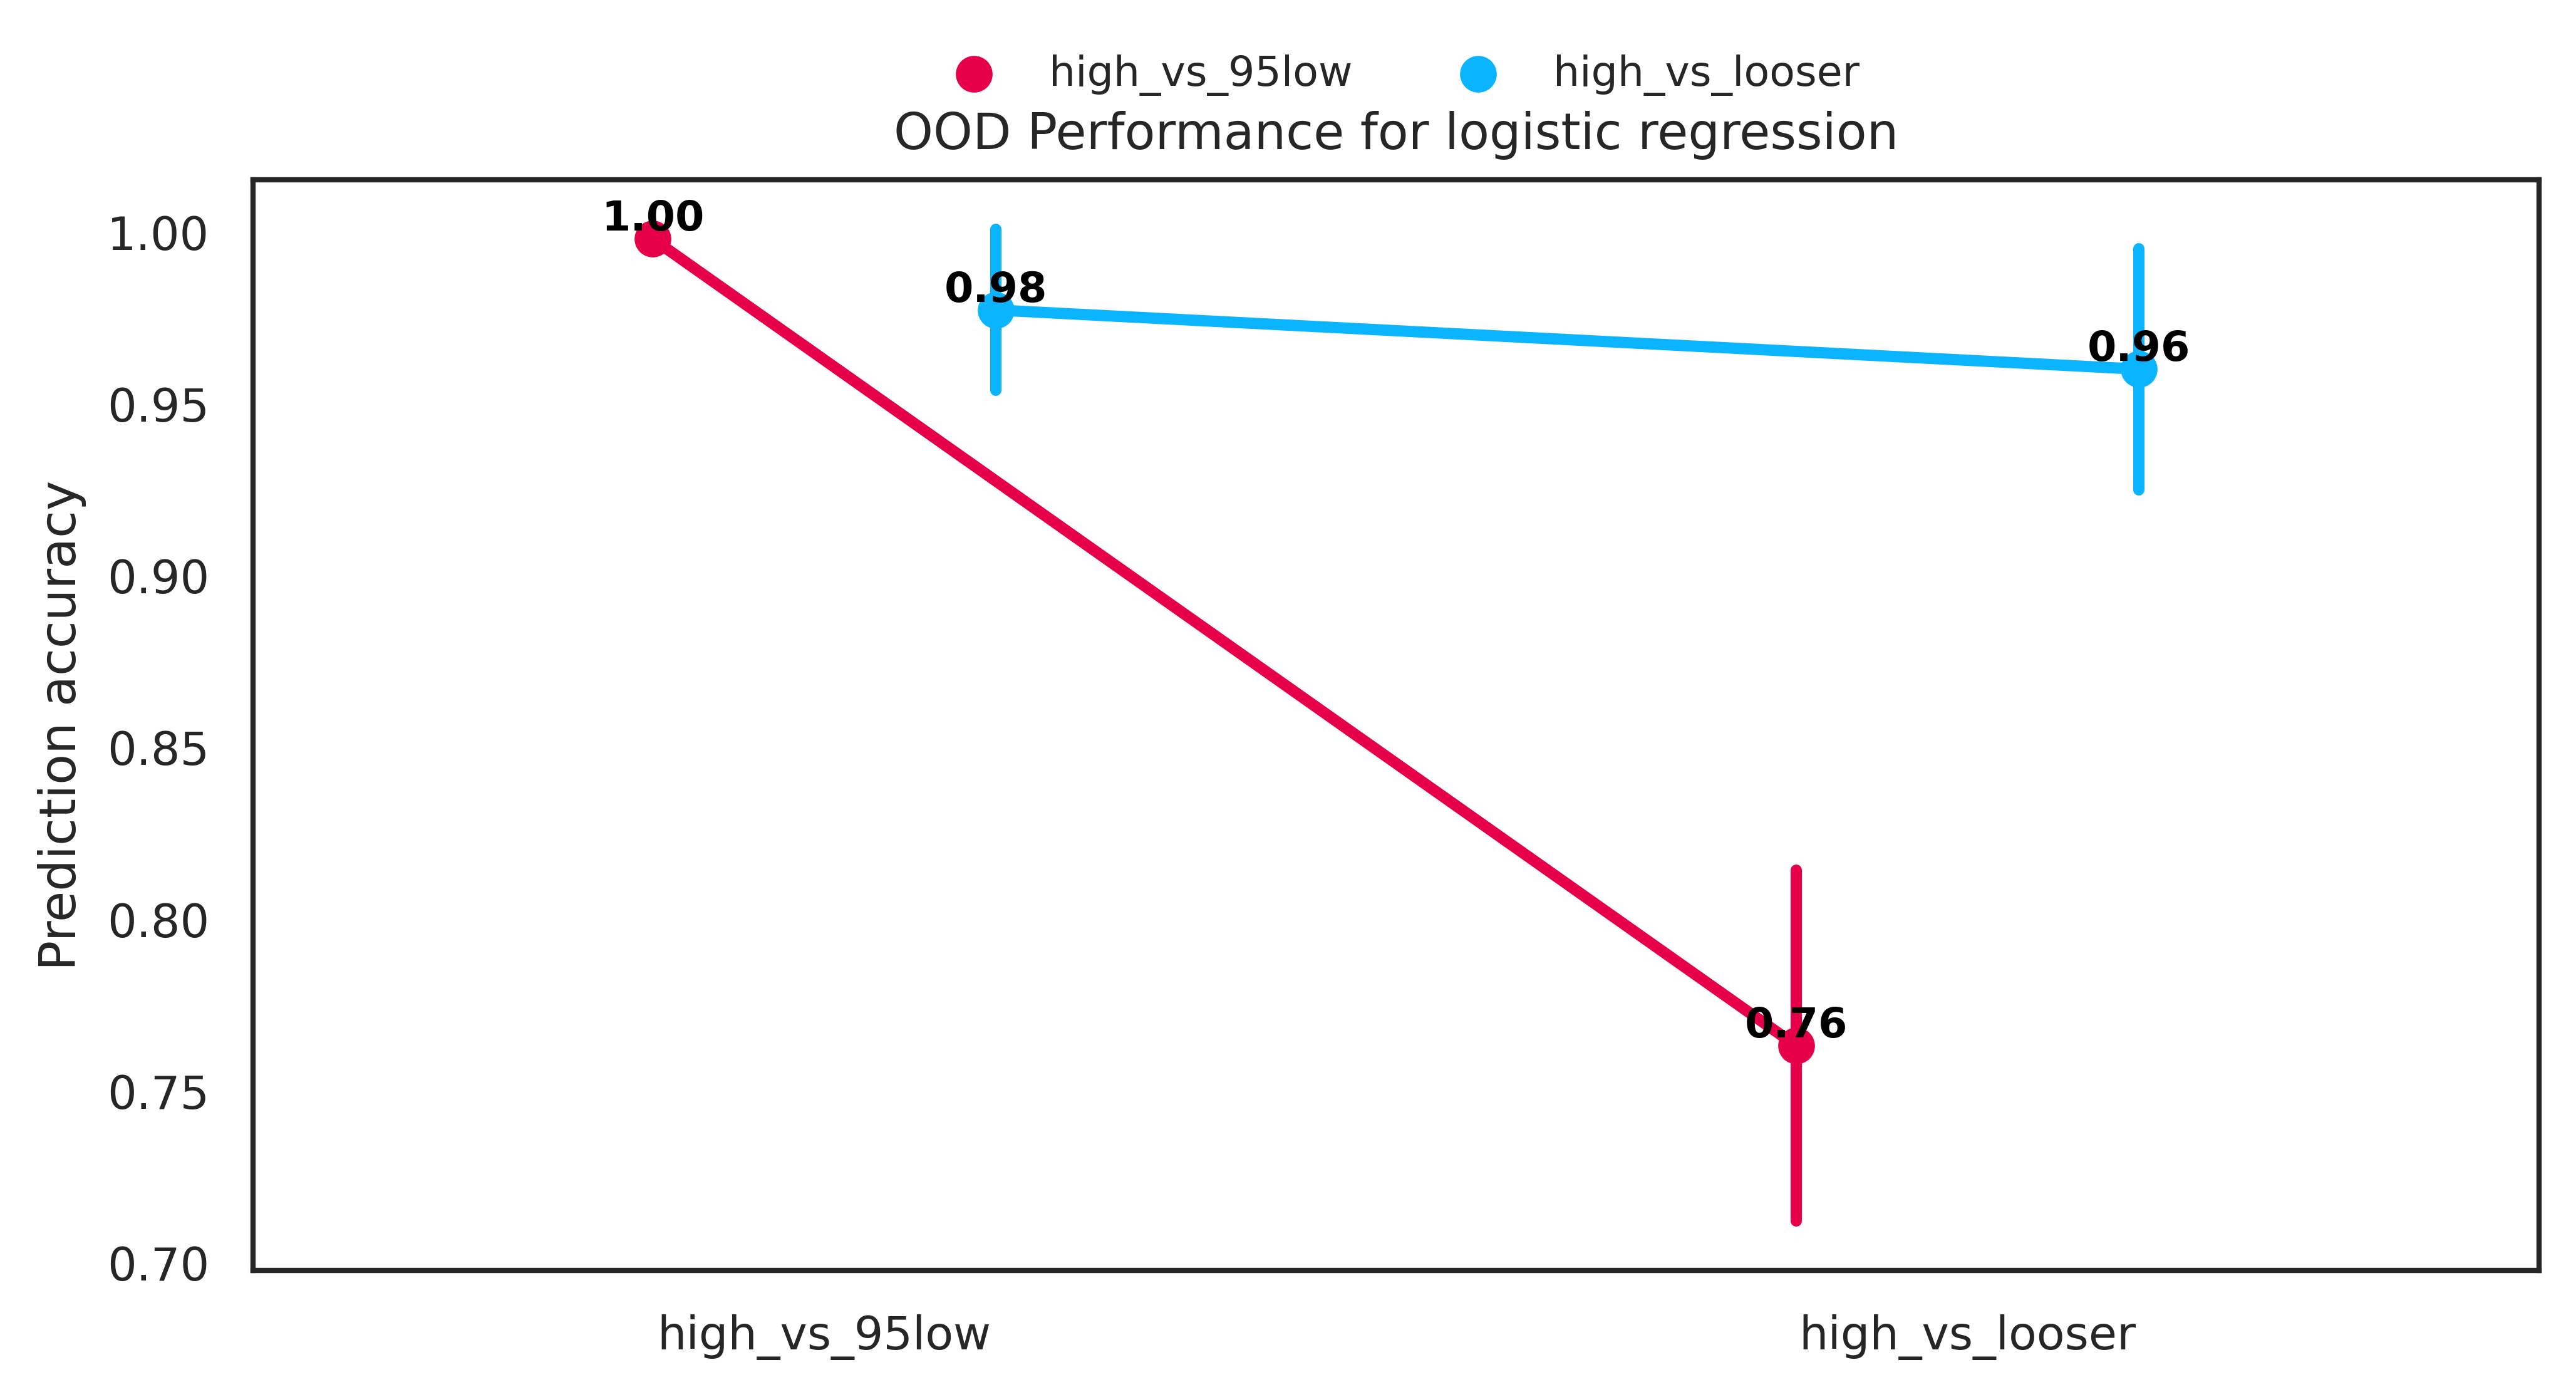

In [37]:
plot_ood(df_ood, task_order=["high_vs_95low","high_vs_looser"])

Rule discovery

Based on nb 07e_Energies_logits.ipynb

In [ ]:
def task_generator_for_epitopes(all_task_types = False):
    if not all_task_types:
        task_types = [
            datasets.ClassificationTaskType.HIGH_VS_95LOW,
            datasets.ClassificationTaskType.HIGH_VS_LOOSER,
        ]
        for task_type in task_types:
            for ag in config.ANTIGEN_EPITOPES:

                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag,
                    ag_neg="auto",
                    seed_id=0,
                    split_id=42,
                )
                yield task
    else:
        
        task_types = [
            datasets.ClassificationTaskType.ONE_VS_ONE,
            datasets.ClassificationTaskType.ONE_VS_NINE,
            datasets.ClassificationTaskType.HIGH_VS_95LOW,
            datasets.ClassificationTaskType.HIGH_VS_LOOSER,
        ]
        # For 1v1
        for ag_1 in config.ANTIGEN_EPITOPES:
            for ag_2 in config.ANTIGEN_EPITOPES:
                if ag_1 == ag_2:
                    continue
                task = datasets.ClassificationTask(
                    task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
                    ag_pos=ag_1,
                    ag_neg=ag_2,
                    seed_id=0,
                    split_id=42,
                )
                yield task

        for task_type in task_types[1:]:
            for ag in config.ANTIGEN_EPITOPES:
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag,
                    ag_neg="auto",
                    seed_id=0,
                    split_id=42,
                )
                yield task
        


loader = datasets.FrozenMiniAbsolutMLLoader(data_dir=Path("../data/Frozen_MiniAbsolut_ML"))

RD: Logits

In [ ]:
from utils_07 import get_miniabsolut_for_epitopes
from scipy.stats import pearsonr


def collect_and_compute_logits_energy_corr(task_generator, fp, force=False, attributions_analysis="v2.0-3-epi"):

    if fp.exists() and not force:
        df_r = pd.read_csv(fp, sep='\t')
    else:
        records = []
        for task in task_generator:

            ## Get attributions and energies
            task = loader.load(task, attributions_toload=attributions_analysis, load_model=True, load_test_dataset=True)    
            
            df = get_miniabsolut_for_epitopes(task)

            ## Compute
            try:
                r, p = pearsonr(df["logits"].dropna(), df["Energy"].dropna())
            except:
                r, p = np.nan, np.nan
            r_pos, p_pos = pearsonr(df[df["y_true"] == 1]["logits"], df[df["y_true"] == 1]["Energy"])
            records.append({
                "task_type": task.task_type.to_str(),
                "ag_pos": task.ag_pos,
                "ag_neg": task.ag_neg,
                "seed_id": task.seed_id,
                "split_id": task.split_id,
                "r": r,
                "p": p,
                "r2": r**2,
                "r_pos": r_pos,
                "r_pos2": r_pos**2,
                "p_pos": p_pos,
                })

        df_r = pd.DataFrame.from_records(records)
        df_r.to_csv(fp, sep='\t', index=False)
    
    return df_r


def plot_logit_energy_corr(df_l):
    fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
    # sns.set_theme(context="paper")
    # sns.set_style("white")

    task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
    sns.stripplot(
        data=df_l, 
        x="task_type", 
        y="r_pos", 
        hue="ag_pos", 
        ax=ax, 
        cmap=visualisations.PlotParams.cmap_antigens,
        order=task_order,
    )

    # Display no legend
    ax.legend_.remove()

    # Relabel xticks
    ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

    # Add median r_pos per task
    r_median_df = df_l.groupby(["task_type"]).agg({"r_pos": "median"})
    for i, row in r_median_df.iterrows():
        ax.text(
            i,
            -0.95,
            f"{row['r_pos']:.2f}",
            # Center center
            horizontalalignment='center',
        )


    ax.set_ylabel("Pearson correlation coefficient")
    ax.set_xlabel("Task")

In [ ]:
fp = Path("25d_Logit_Energies.tsv")
attributions_analysis = "v2.0-3-epi"
force = False

df_logits = collect_and_compute_logits_energy_corr(
    task_generator_for_epitopes(), 
    fp, 
    force, 
    attributions_analysis
)

In [ ]:
df_logits.groupby(["task_type"]).agg({"r_pos": ["min", "median", "max"]})

r_pos                    
                     min    median       max
task_type                                   
high_vs_95low  -0.916311 -0.790219 -0.688886
high_vs_looser -0.954289 -0.901882 -0.888273

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/tmp/ipykernel_2998247/3112617140.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


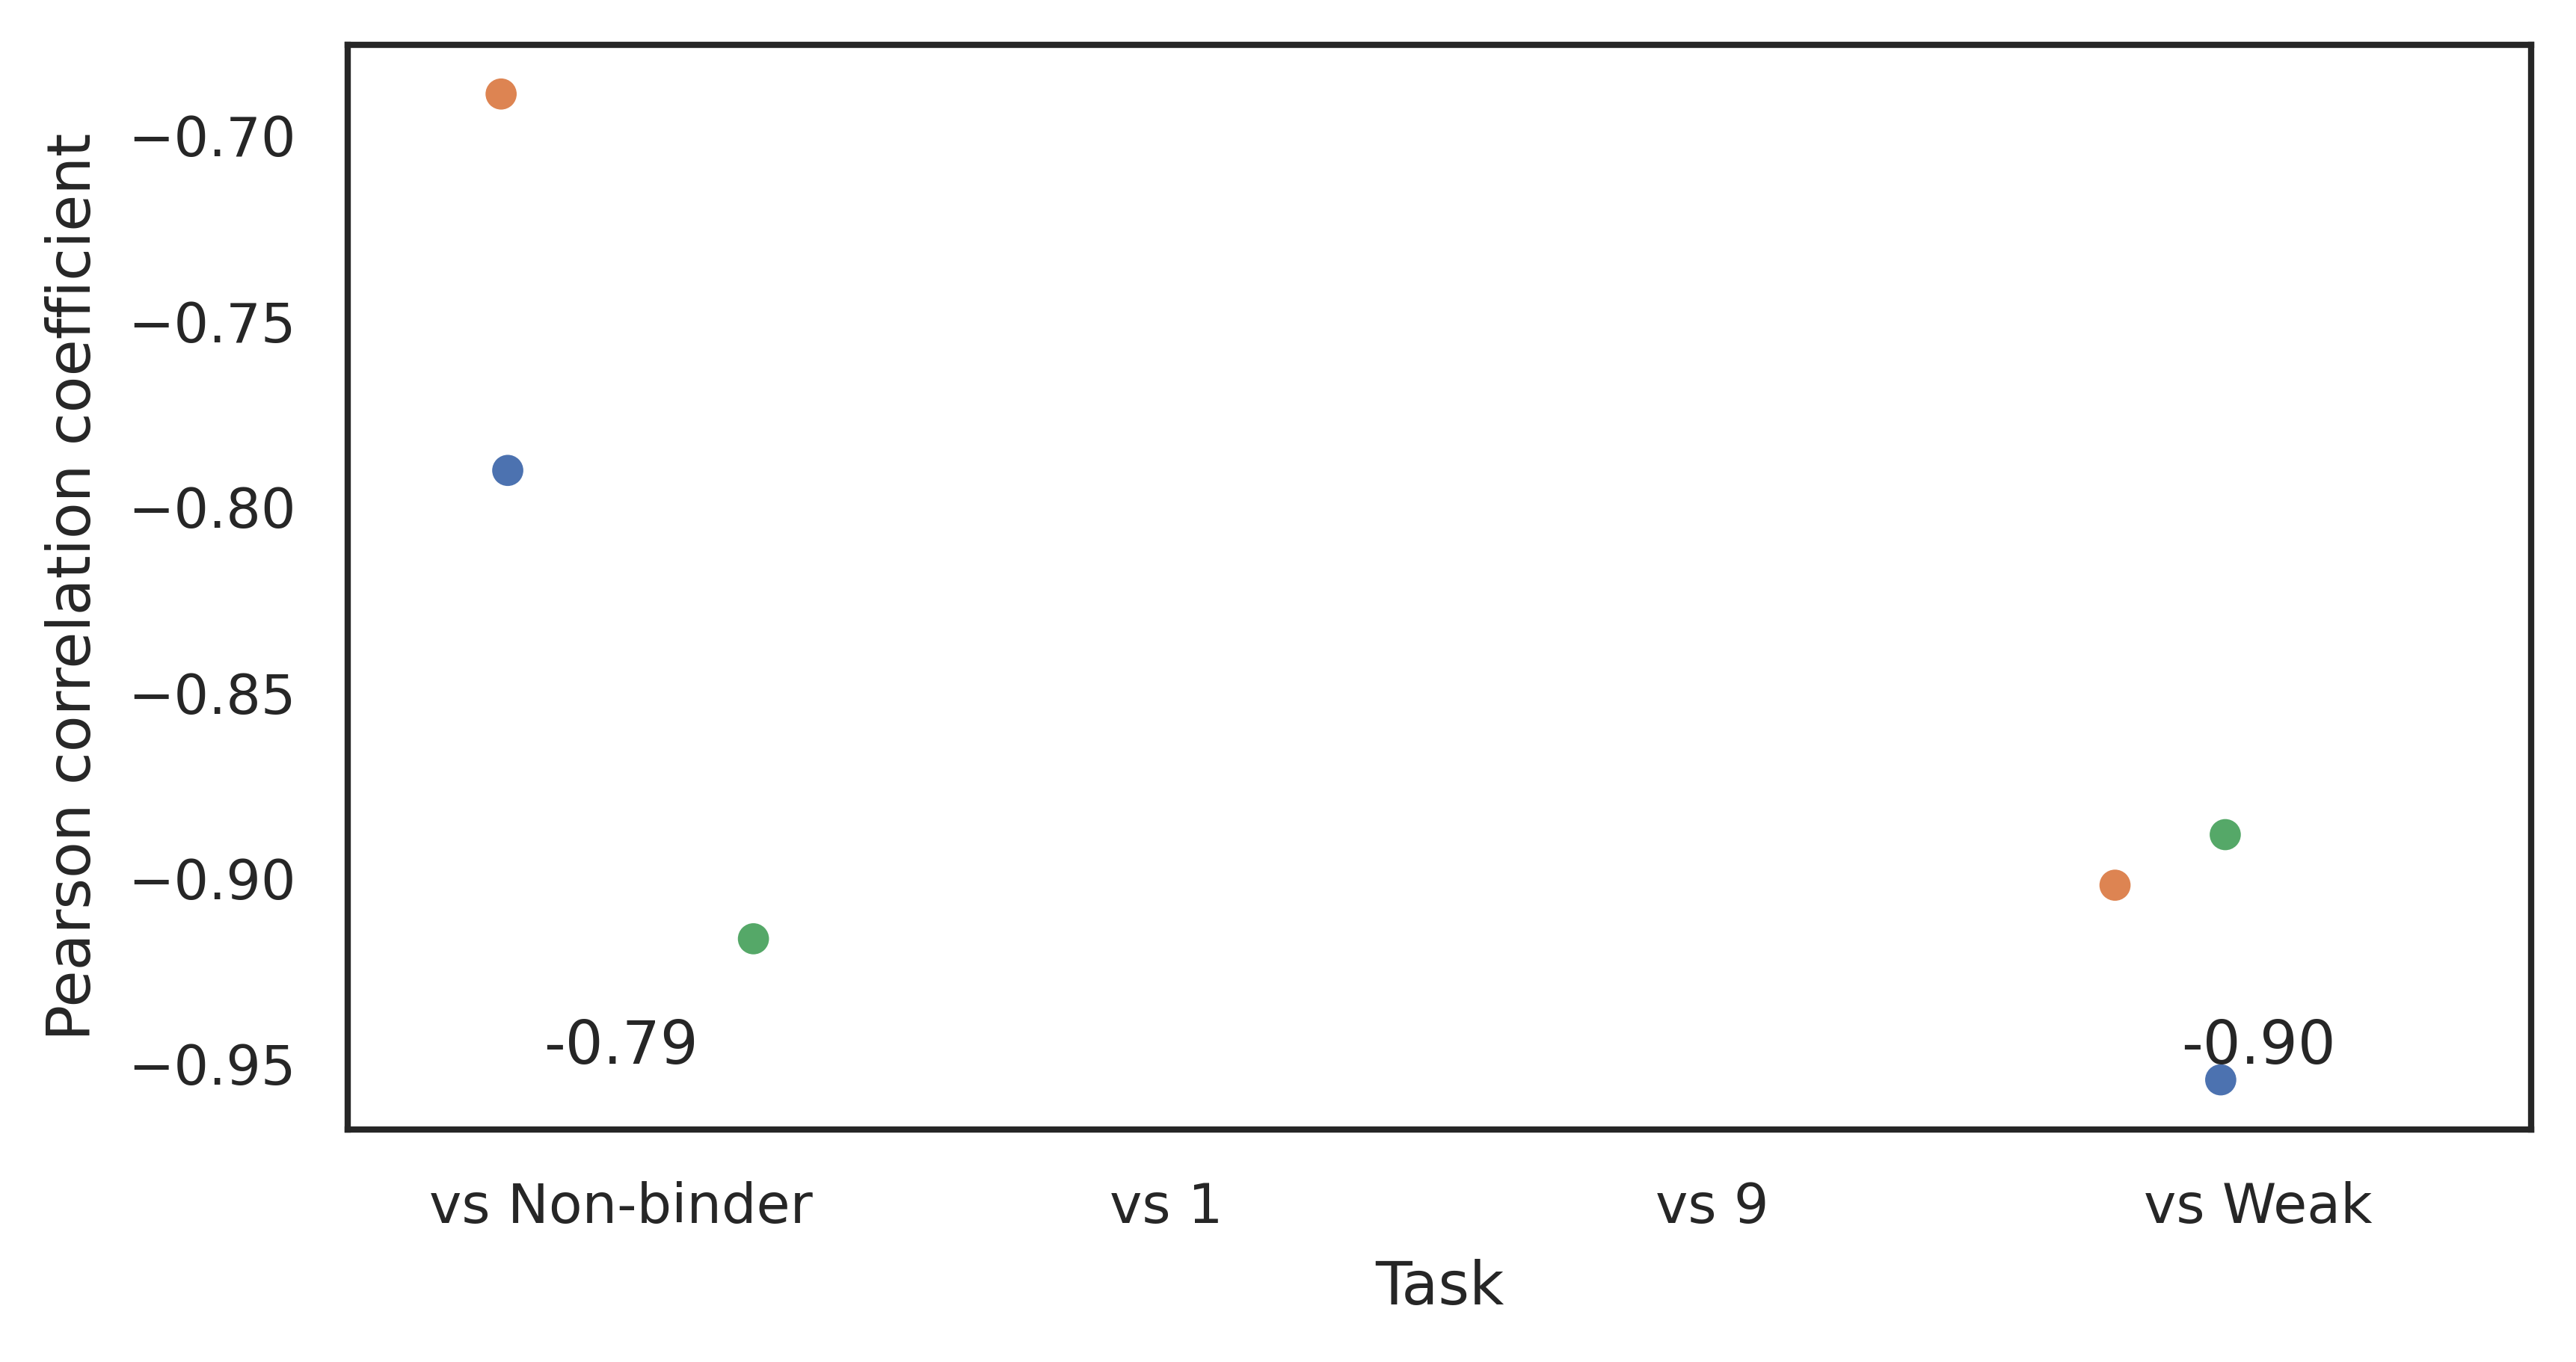

In [ ]:
plot_logit_energy_corr(df_logits)

RD: Attributions

In [ ]:
from utils_07 import load_energy_contributions_from_task_nonlinear_version


def collect_and_compute_attrs_energy_corr(
    task_generator, 
    fp, 
    analysis_name, 
    force=False,
):
    
    if Path(fp).exists() and not force:
        df_attrib = pd.read_csv(fp, sep="\t")
    else:

        records = []
        for task in task_generator:        
            task = loader.load(task, attributions_toload=analysis_name, load_model=False, load_test_dataset=False)
            stats = load_energy_contributions_from_task_nonlinear_version(
                task, 
                load_slide_df=False, 
                load_everything=False,
                attributor_name=f"DeepLIFT_LOCAL_{analysis_name}",
                attribution_records_toload="attribution_records.json",
                task_is_loaded=True,
                load_miniabsolut_for_shuffled=False,
                attr_analysis_name=analysis_name,
                load_miniabsolut_type="epitope_analysis",
                )
            records.append(stats)

        df_attrib = pd.DataFrame.from_records(records)
        df_attrib.to_csv(fp, index=False, sep='\t')
    
    return df_attrib


def plot_attr_energy_corr(df_attrib):

    fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
    sns.set_theme(context="paper")
    sns.set_style("white")

    task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
    sns.stripplot(
        data=df_attrib, 
        x="task_type", 
        y="mean_pos_total", 
        order=task_order,
        hue="ag_pos",
        ax=ax,
        cmap=visualisations.PlotParams.cmap_antigens,
    )

    ax.legend_.remove()

    # Relabel xticks
    ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

    # Add median r_pos per task
    r_median_df = df_attrib.groupby(["task_type"]).agg({"mean_pos_total": "median"})
    for i, row in r_median_df.iterrows():
        ax.text(
            i,
            -0.87,
            f"{row['mean_pos_total']:.2f}",
            # Center center
            horizontalalignment='center',
        )

    # ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
    ax.set_ylabel("Pearson correlation coefficient")
    ax.set_xlabel("Task")

In [ ]:
fp = "25d_Attribution_Energies.tsv"
analysis_name = "v2.0-3-epi"
force = False

df_attr = collect_and_compute_attrs_energy_corr(
    task_generator_for_epitopes(),
    fp,
    analysis_name,
    force=force,
)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/tmp/ipykernel_2998247/2872020853.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


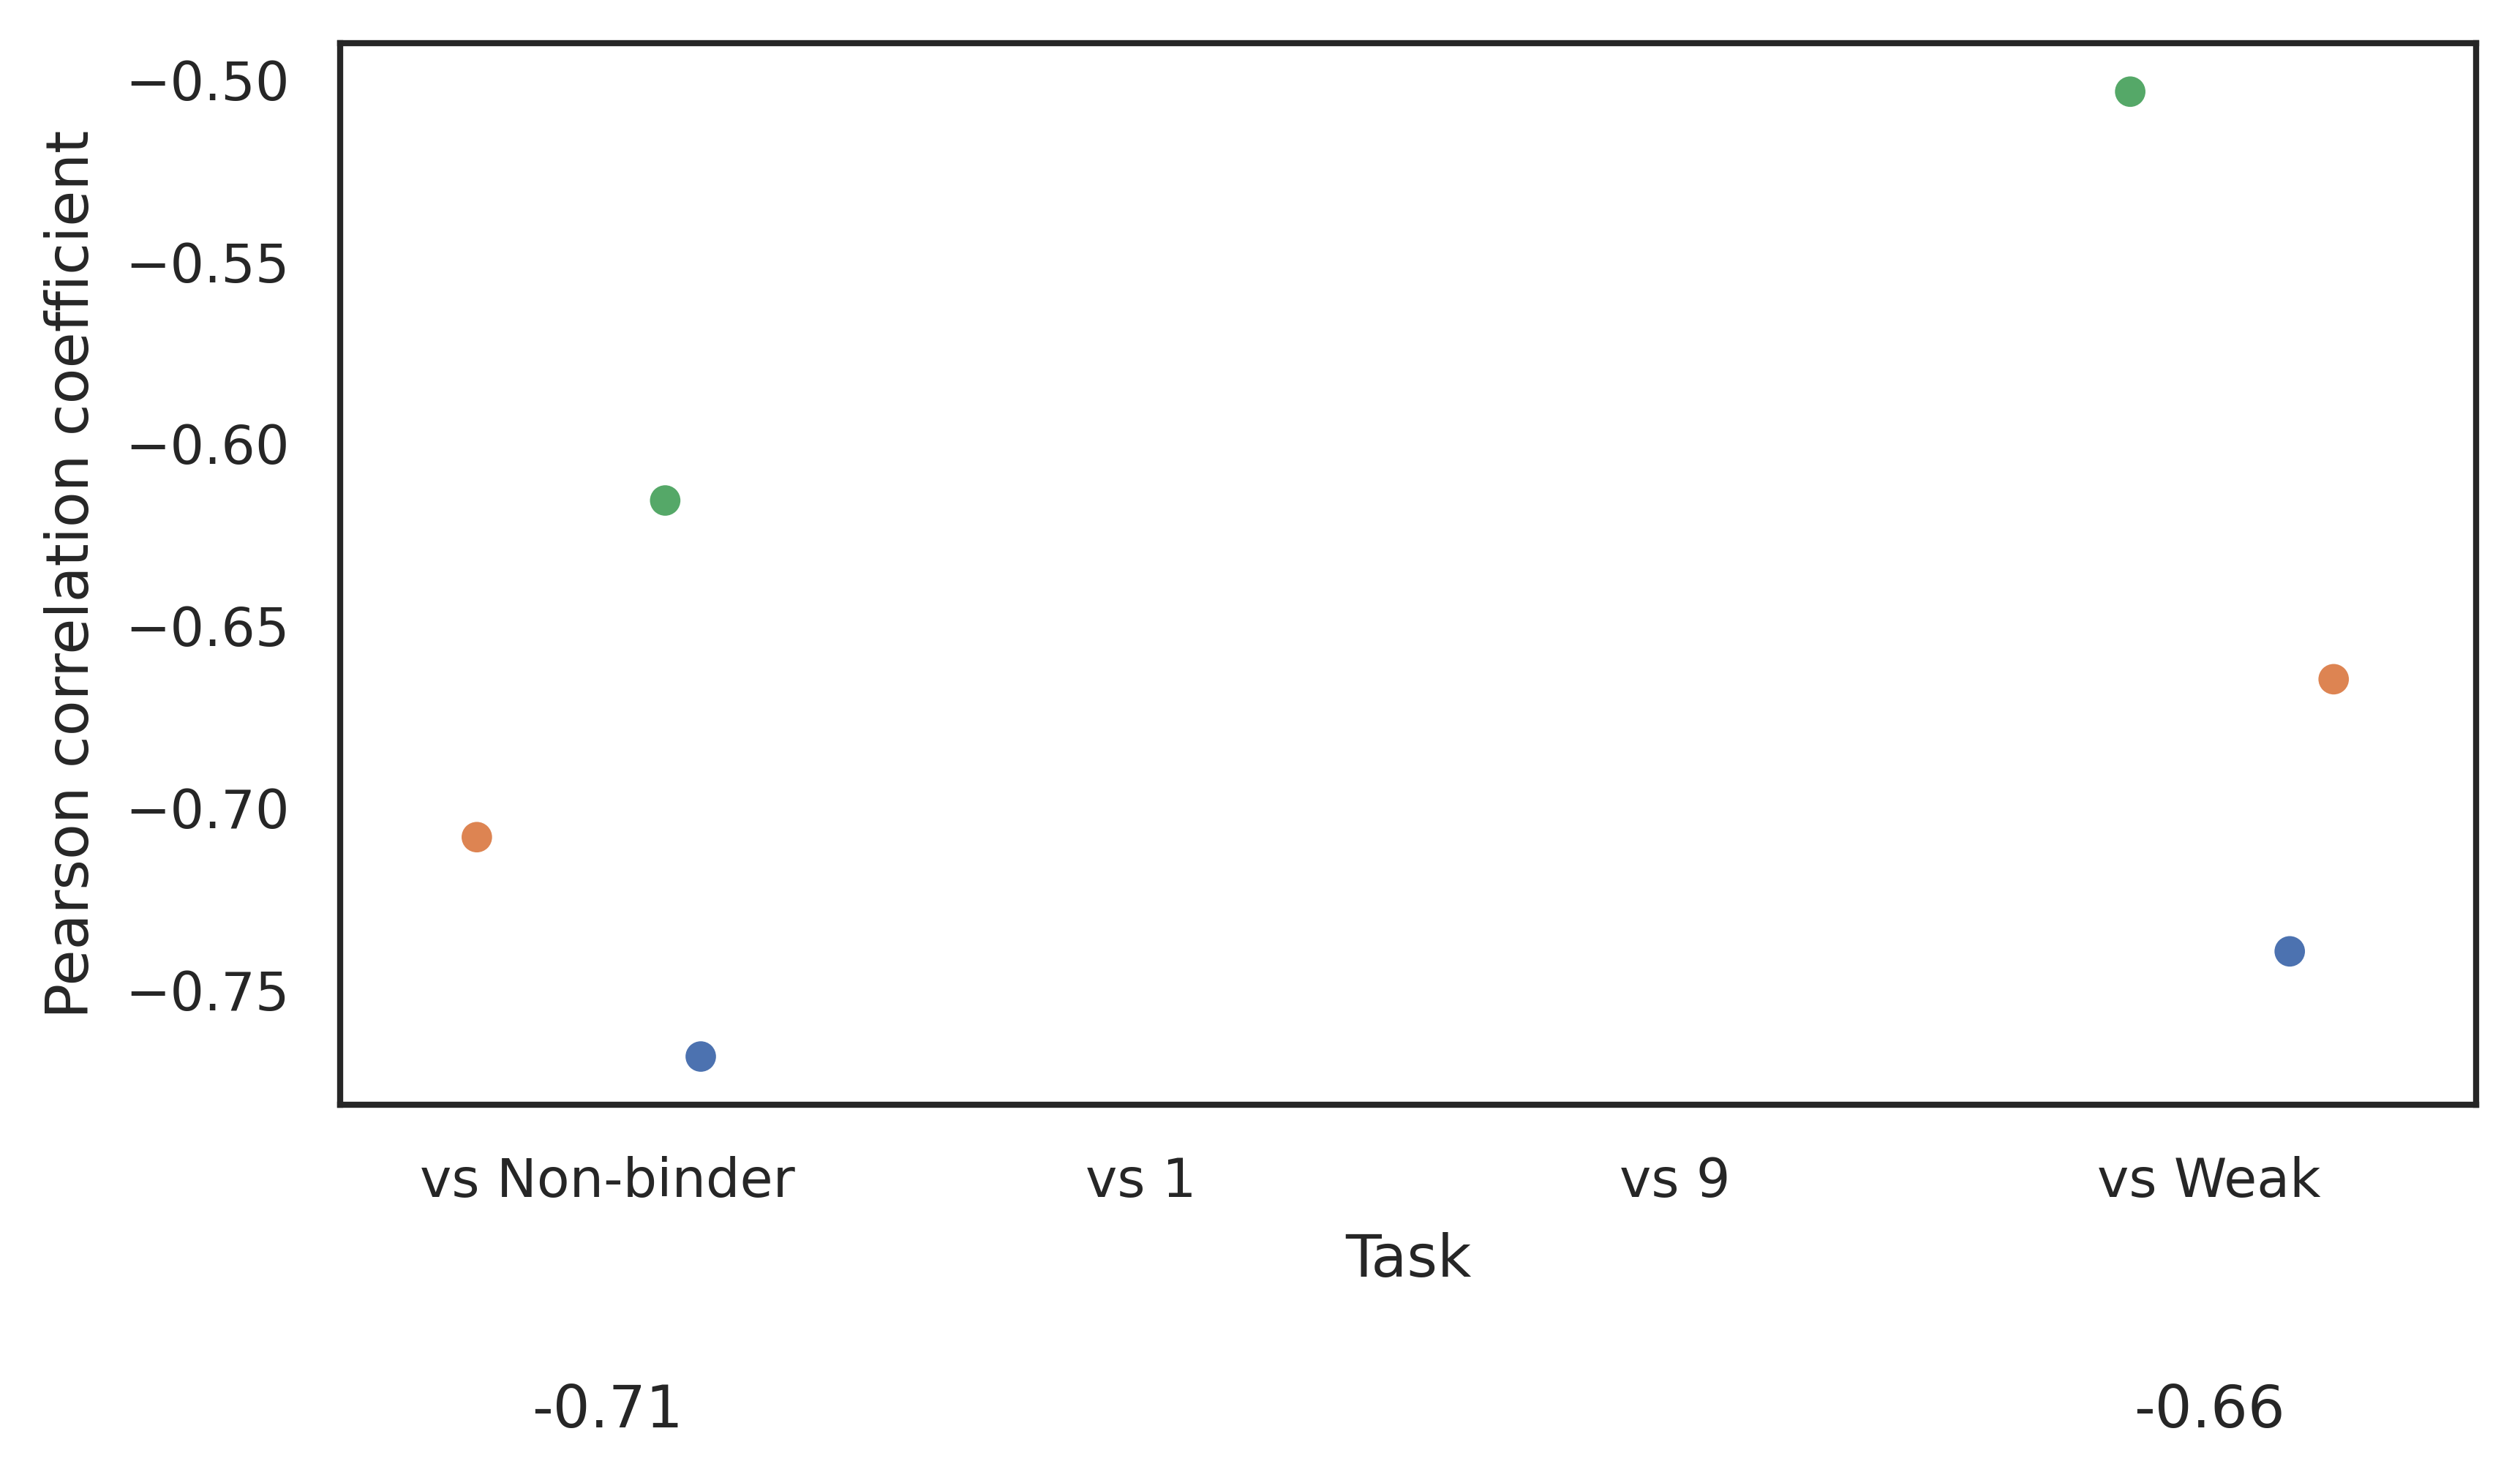

In [ ]:
plot_attr_energy_corr(df_attr)

Do logits and attributions for epipos

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/tmp/ipykernel_2998247/3112617140.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


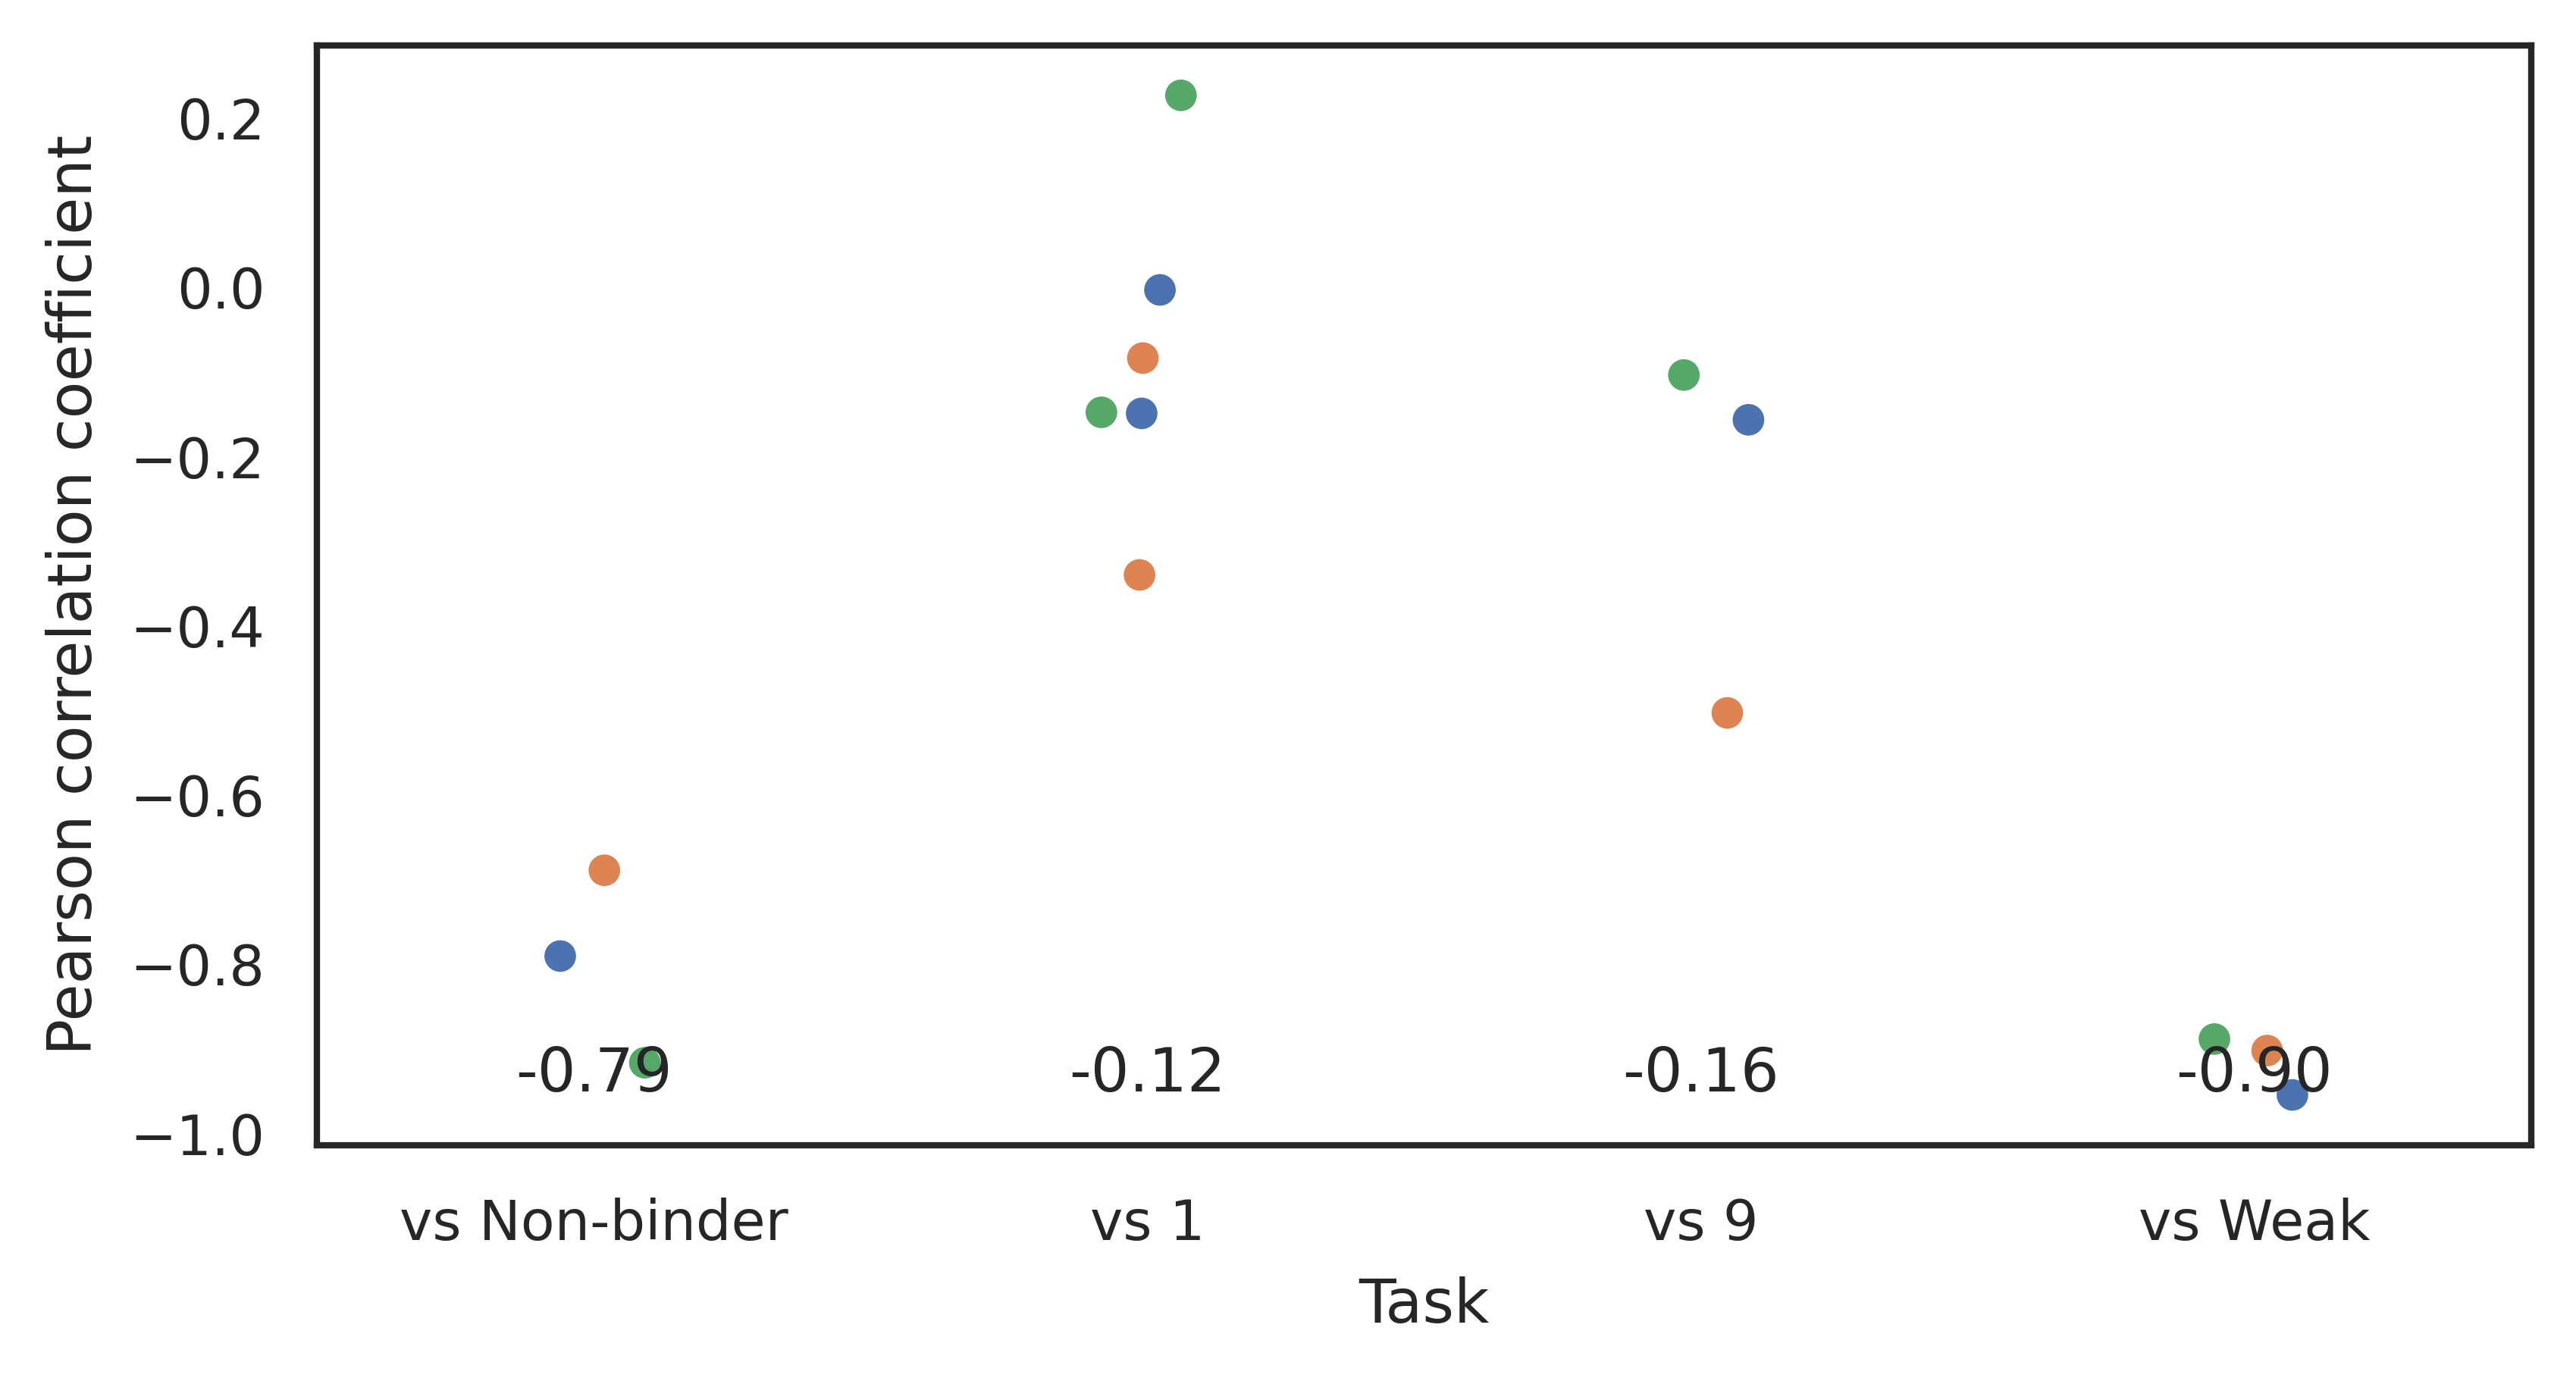

In [ ]:
fp = Path("25d_Logit_Energies_EpiPos.tsv")
attributions_analysis = "v2.0-3-epipos"
force = False


df_logits = collect_and_compute_logits_energy_corr(
    task_generator_for_epitopes(all_task_types=True), 
    fp, 
    force, 
    attributions_analysis
)

df_logits.groupby(["task_type"]).agg({"r_pos": ["min", "median", "max"]})

plot_logit_energy_corr(df_logits)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/tmp/ipykernel_2998247/2872020853.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


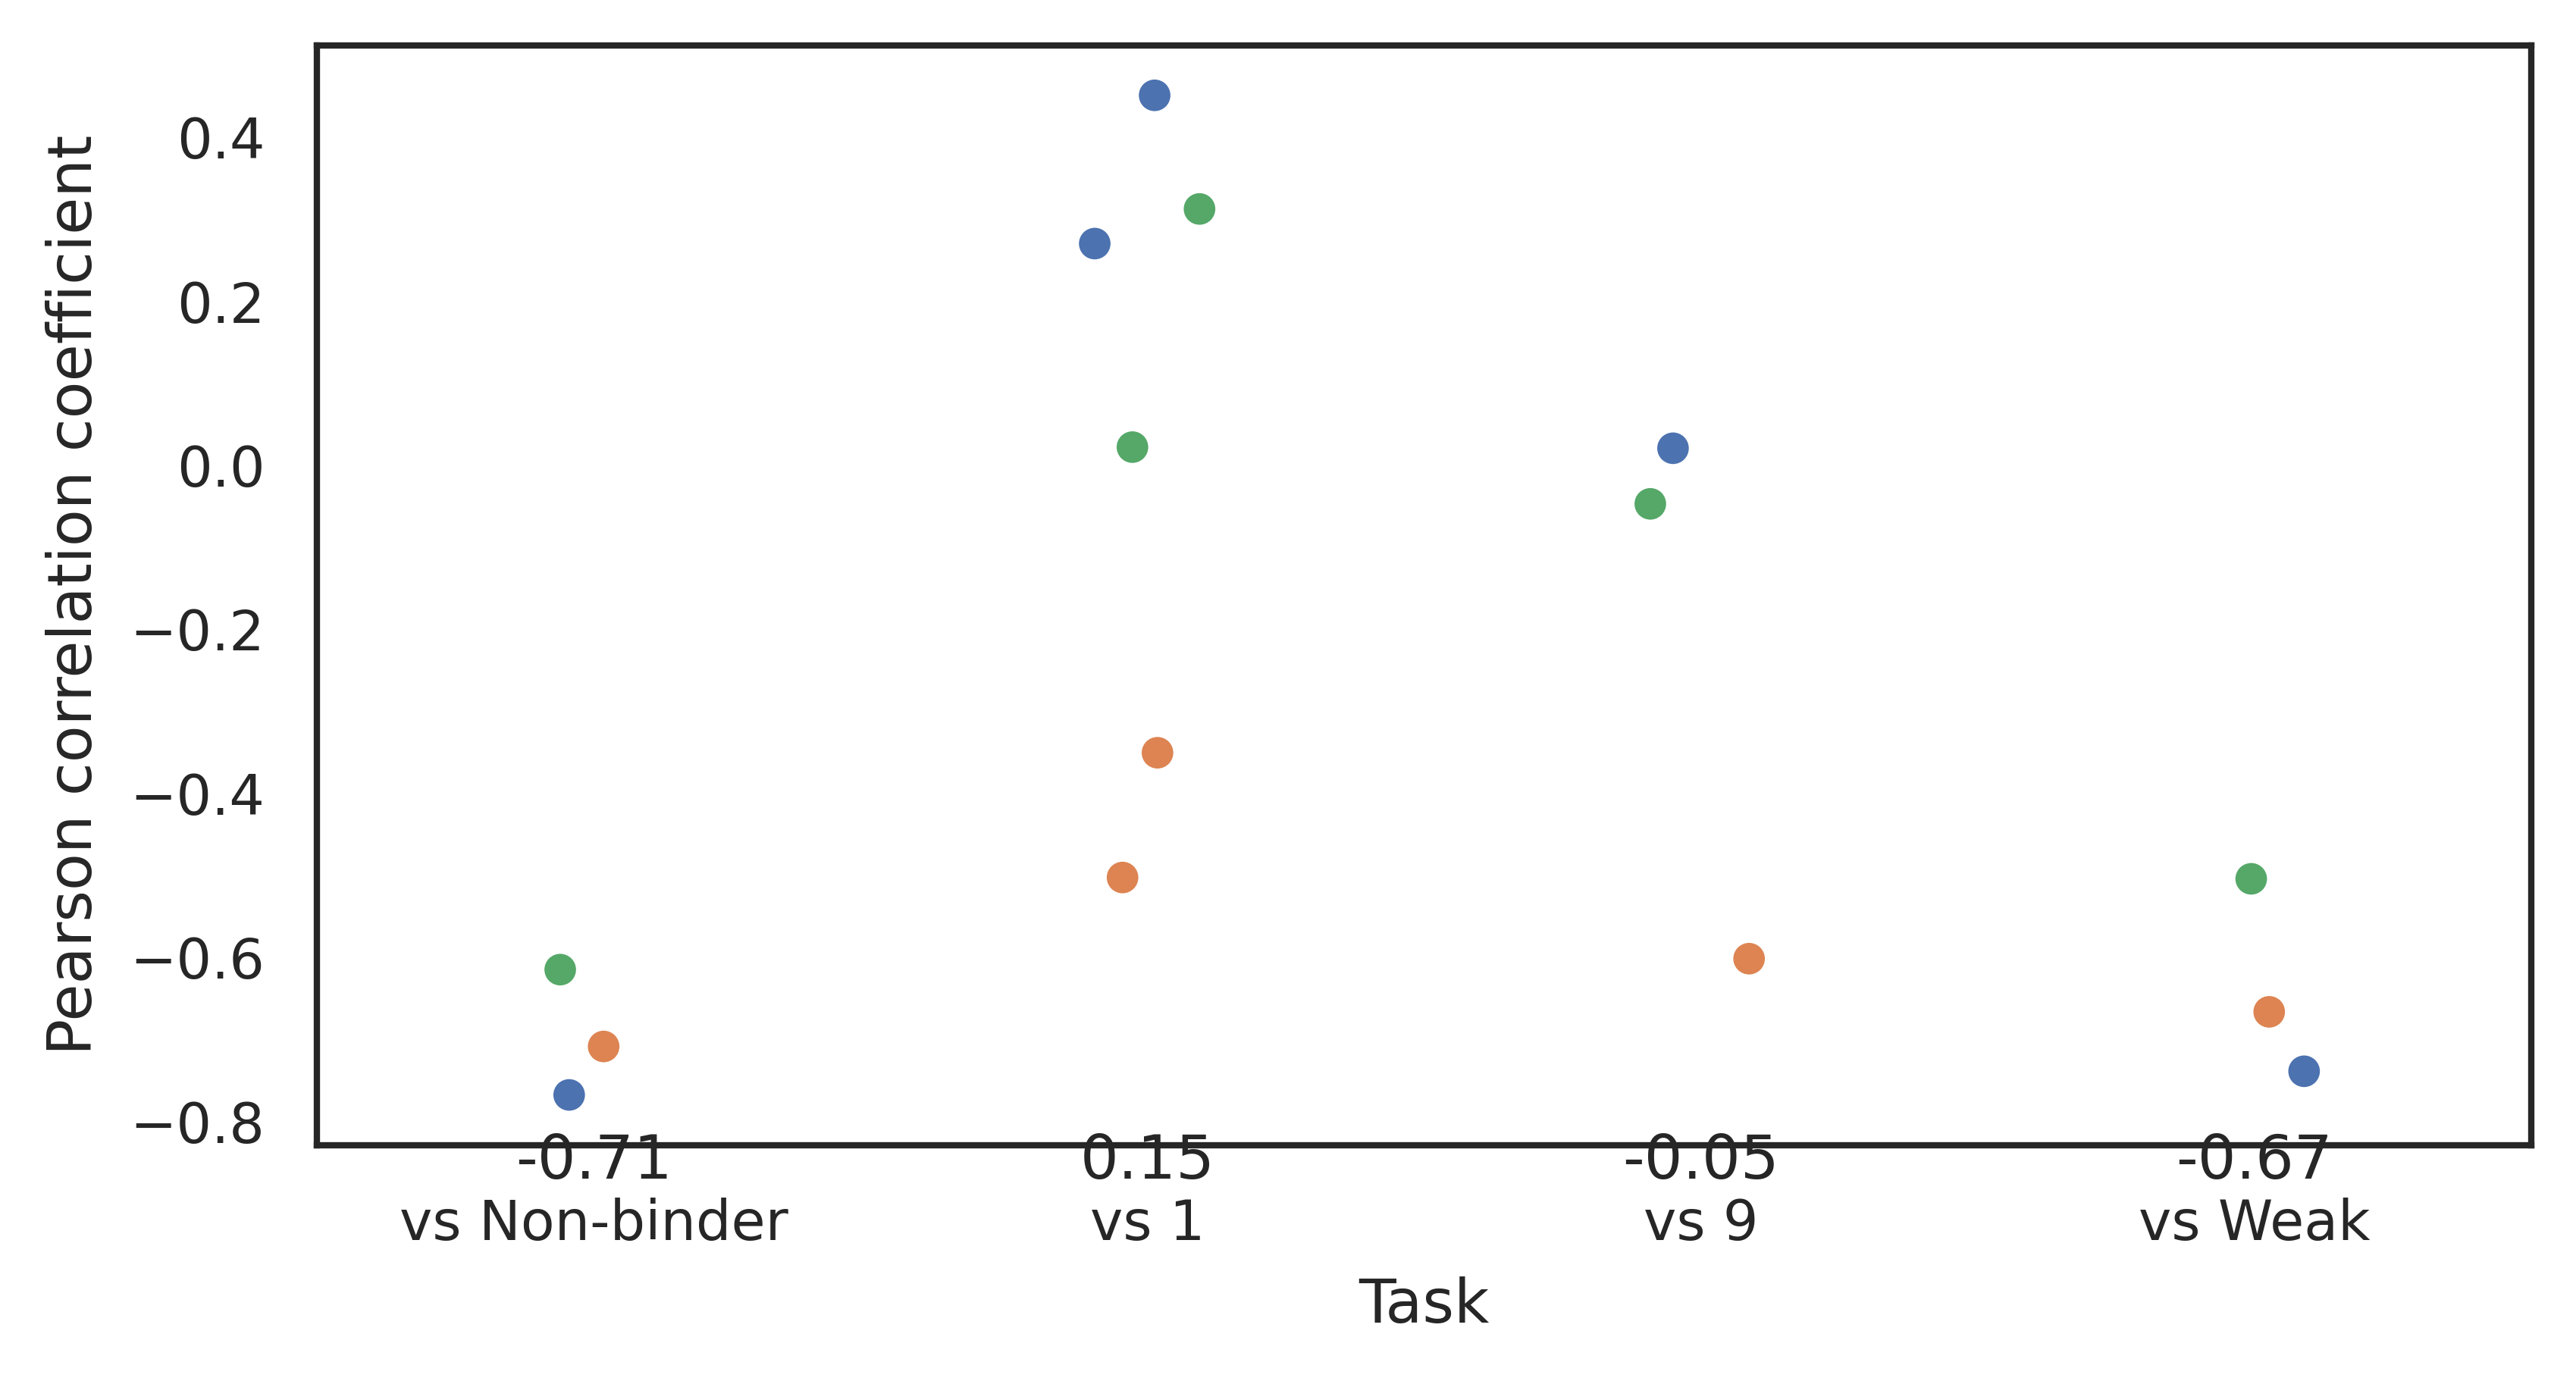

In [ ]:
fp = "25d_Attribution_Energies_EpiPos.tsv"
analysis_name = "v2.0-3-epipos"
force = False

df_attr = collect_and_compute_attrs_energy_corr(
    task_generator_for_epitopes(all_task_types=True),
    fp,
    analysis_name,
    force=force,
)

plot_attr_energy_corr(df_attr)